<center>
    <div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/%C3%89cole_polytechnique_signature.svg/langfr-180px-%C3%89cole_polytechnique_signature.svg.png" width="150" height="200">
    </div>
    <br>
  <center> <font color=#023F7C size=4>APM_43M02_EP - Modal - Simulation numérique aléatoire (SNA) autour des évènements rares</font> <br></center>
  <center><font color='#023F7C' size="6.5">Risques extrêmes en finance de marché </font> <br></center>

</center>

<font color="#023F7C">**Par**:</font> 
- **Dzikouk Frank Dilane**, Second year student at Ecole Polytechnique <br>
- **Christel Astride Mallo Poundi**, Second year student at Ecole Polytechnique <br>

## __Importation des librairies utiles__ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from joblib import Parallel, delayed
from scipy.stats import gaussian_kde
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import norm
import time

In [2]:
will = True
#will = False

def reproductivité(volonté) :
    if volonté : 
        np.random.seed(42)
    else :
        pass

## __Codes utiles__ 

Dans cette section, nous implémentons les fonctions nécessaires à la valorisation d’options selon le modèle de Black-Scholes.

Nous codons les fonctions suivantes :
- Calcul de la valeur d’une option **call** européenne
- Calcul de la valeur d’une option **put** européenne
- Calcul de la valeur d’un **portefeuille** non couvert composé de ces options

In [40]:
# Fonctions de Black-Scholes
def d_po(t: float, x: float, y: float, sigma: float) -> float:
    """
    Calcule d_plus (noté d1 dans Black-Scholes).
    
    Paramètres :
    - t : float, temps restant jusqu’à l’échéance (T - t)
    - x : float, prix de l’actif sous-jacent
    - y : float, prix d’exercice de l’option
    - sigma : float, volatilité du sous-jacent
    
    Retourne :
    - d_plus : float, la quantité d1 dans le modèle de Black-Scholes
    """
    return 1 / (sigma * np.sqrt(t)) * np.log(x / y) + sigma * np.sqrt(t) / 2

def d_ne(t: float, x: float, y: float, sigma: float) -> float:
    """
    Calcule d_minus (noté d2 dans Black-Scholes).
    
    Paramètres :
    - t : float, temps restant jusqu’à l’échéance (T - t)
    - x : float, prix de l’actif sous-jacent
    - y : float, prix d’exercice de l’option
    - sigma : float, volatilité du sous-jacent
    
    Retourne :
    - d_minus : float, la quantité d2 dans le modèle de Black-Scholes
    """
    return 1 / (sigma * np.sqrt(t)) * np.log(x / y) - sigma * np.sqrt(t) / 2

def Call(T: float, t: float, S_t: float, K: float, sigma: float) -> float:
    """
    Calcule la valeur d’une option call européenne selon Black-Scholes.
    
    Paramètres :
    - T : float, maturité de l’option
    - t : float, temps actuel
    - S_t : float, prix actuel de l’actif sous-jacent
    - K : float, prix d’exercice
    - sigma : float, volatilité de l’actif
    
    Retourne :
    - valeur du call : float
    """
    tau = T - t
    if tau <= 0:
        return max(S_t - K, 0)
    d1 = d_po(tau, S_t, K, sigma)
    d2 = d_ne(tau, S_t, K, sigma)
    return S_t * stats.norm.cdf(d1) - K * stats.norm.cdf(d2)

def Put(T: float, t: float, S_t: float, K: float, sigma: float) -> float:
    """
    Calcule la valeur d’une option put européenne selon Black-Scholes.
    
    Paramètres :
    - T : float, maturité de l’option
    - t : float, temps actuel
    - S_t : float, prix actuel de l’actif sous-jacent
    - K : float, prix d’exercice
    - sigma : float, volatilité de l’actif
    
    Retourne :
    - valeur du put : float
    """
    tau = T - t
    if tau <= 0:
        return max(K - S_t, 0)
    d1 = d_po(tau, S_t, K, sigma)
    d2 = d_ne(tau, S_t, K, sigma)
    return K * stats.norm.cdf(d2) - S_t * stats.norm.cdf(d1)

def valeur_portefeuille(alpha: np.ndarray, beta: np.ndarray, S_t: np.ndarray, t: float, T: float, K: float, sigma: float) -> float:
    """
    Calcule la valeur d’un portefeuille d’options (pondération de calls et puts).
    
    Paramètres :
    - alpha : np.ndarray, poids des options call dans le portefeuille
    - beta : np.ndarray, poids des options put dans le portefeuille
    - S_t : np.ndarray, prix des actifs sous-jacents
    - t : float, temps actuel
    - T : float, maturité des options
    - K : float, prix d’exercice
    - sigma : float, volatilité des actifs
    
    Retourne :
    - valeur totale du portefeuille : float
    """
    calls = np.array([Call(T, t, s, K, sigma) for s in S_t])
    puts = np.array([Put(T, t, s, K, sigma) for s in S_t])
    return np.sum(alpha * calls + beta * puts)


## __Simulation de l'évolution de la valeur du portefeuille__

Dans cette partie, nous allons implémenter une fonction `simulation` qui, à partir des paramètres du portefeuille, permet de :

1. **Tracer l'évolution de la valeur du portefeuille** $ V(t) $ au cours du temps.
2. **Tracer la valeur cumulée** $ V(0) - V(t) $ représentant la perte (ou le gain) de valeur au fil du temps.
3. **Tracer les trajectoires des actifs sous-jacents** simulés selon un mouvement brownien géométrique.

In [41]:
def simulation(alpha: np.ndarray, beta: np.ndarray, T: float, K: float, sigma: float, S0: float, N: int, I0: int) :
    
    t_grid = np.linspace(0, T, N + 1)
    dt = T/N
    # Simulation des trajectoires de S_t
    S_paths = np.zeros((I0, N + 1))
    for i in range(I0):
        W = np.zeros(N + 1)
        W[1:] = np.cumsum(np.sqrt(dt) * np.random.randn(N))
        S_paths[i] = S0 * np.exp(-0.5 * sigma**2 * t_grid + sigma * W)

    # Évolution de la valeur du portefeuille dans le temps
    V_t_series = np.zeros(N + 1)
    V_t_series_patch = np.zeros(N + 1)
    for n in range(N + 1):
        S_t_now = S_paths[:, n]
        t_now = t_grid[n]
        V_t_series[n] = valeur_portefeuille(alpha, beta, S_t_now, t_now, T, K, sigma)
    # Affichage des trajectoires de S(t), de la valeur du portefeuille et de la valeur sans saut à maturité
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 ligne, 3 colonnes

    # Sous-graphe 1 : Trajectoires de S(t)
    for i in range(I0):
        axes[0].plot(t_grid, S_paths[i], label=f"Simulation {i+1}")
    axes[0].set_title("Mouvement brownien géométrique - 10 simulations")
    axes[0].set_xlabel("Temps")
    axes[0].set_ylabel("S(t)")
    axes[0].grid(True)
    axes[0].legend()

    # Sous-graphe 2 : Valeur du portefeuille
    axes[1].plot(t_grid, V_t_series[0] - V_t_series, color='black', lw=2, label="Valeur cumulée V(0)- V(t)")
    axes[1].plot(t_grid, V_t_series, color='red', lw=2, label="Valeur du portefeuille V(t)")
    axes[1].set_title("Évolution de la valeur du portefeuille")
    axes[1].set_xlabel("Temps")
    axes[1].set_ylabel("V(0)-V(t)")
    axes[1].legend()
    axes[1].grid(True)
    """
    # Sous-graphe 3 : Valeur sans saut à maturité
    axes[2].plot(t_grid[:-1], V_t_series[0] - V_t_series[:-1], color='black', lw=2, label="Valeur cumulée V(0)- V(t)")
    axes[2].plot(t_grid[:-1], V_t_series[:-1], color='red', lw=2, label="Valeur du portefeuille V(t)")
    axes[2].set_title("Valeur sans saut à maturité")
    axes[2].set_xlabel("Temps")
    axes[2].set_ylabel("V(0)-V(t)")
    axes[2].legend()
    axes[2].grid(True)
    """
    # Titre global pour les trois graphiques
    fig.suptitle(f"Évolution de la valeur du portefeuille (sigma={sigma}, alpha={alpha}, beta={beta})", fontsize=16)

    # Ajustement des espaces entre les sous-graphiques
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Laisser de l'espace pour le titre global
    plt.show()



### Mise en œuvre pour les trois portefeuilles présentés dans le sujet

Portefeuille 1 :   $I_0 = 10 $ , $ \alpha_i = 10 $, $ \beta_i = 5 $, $ \forall i $ ;

Portefeuille 2 :   $I_0 = 10 $ , $ \alpha_i = -10 $, $ \beta_i = -5 $, $ \forall i $ ;

Portefeuille 3 :   $I_0 = 10 $ , $ \alpha_i = 10 $, $ \beta_i = 5 $, $ \forall i \in \{1, \ldots, 5\}$  et  $ \alpha_i = -10 $, $ \beta_i = -5 $, $ \forall i \in \{6, \ldots, 10\}$

Running simulation for portfolio 1...


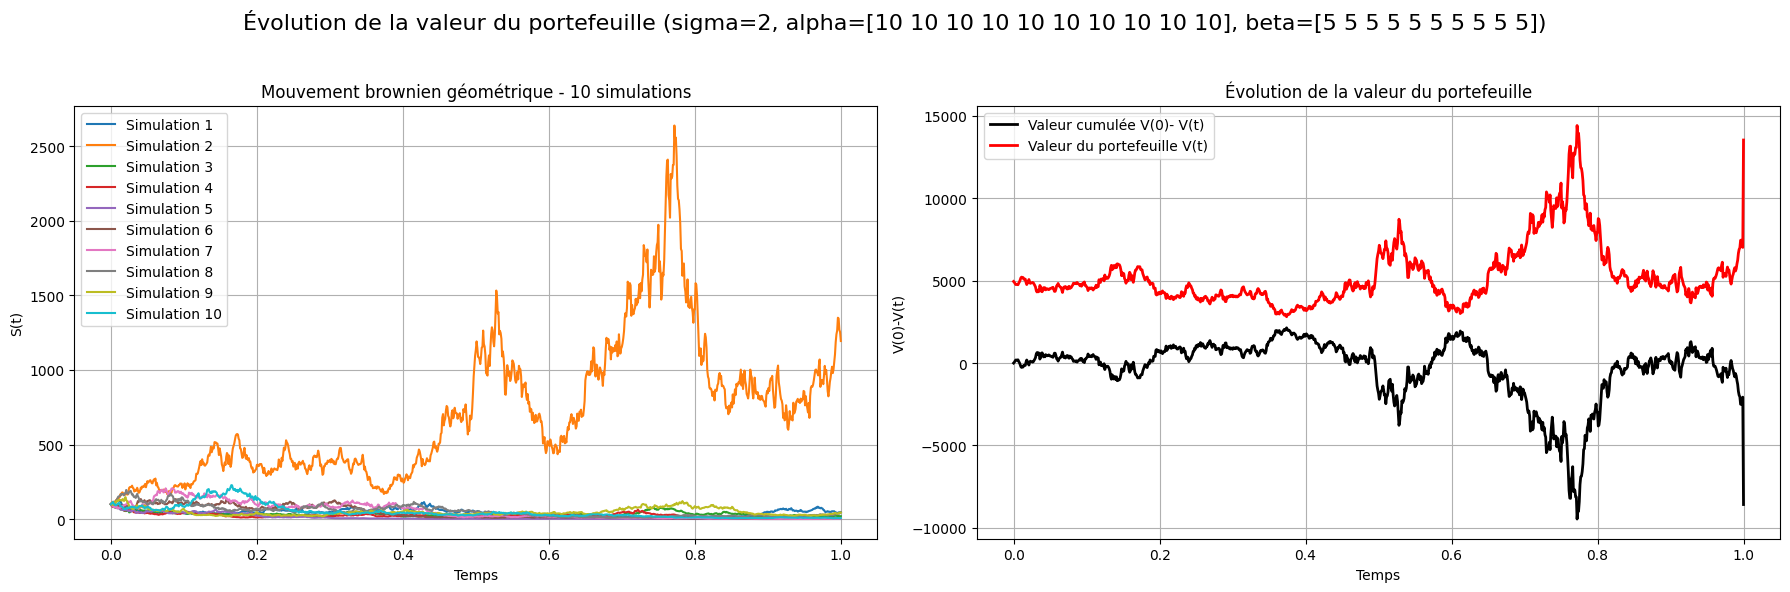

Running simulation for portfolio 2...


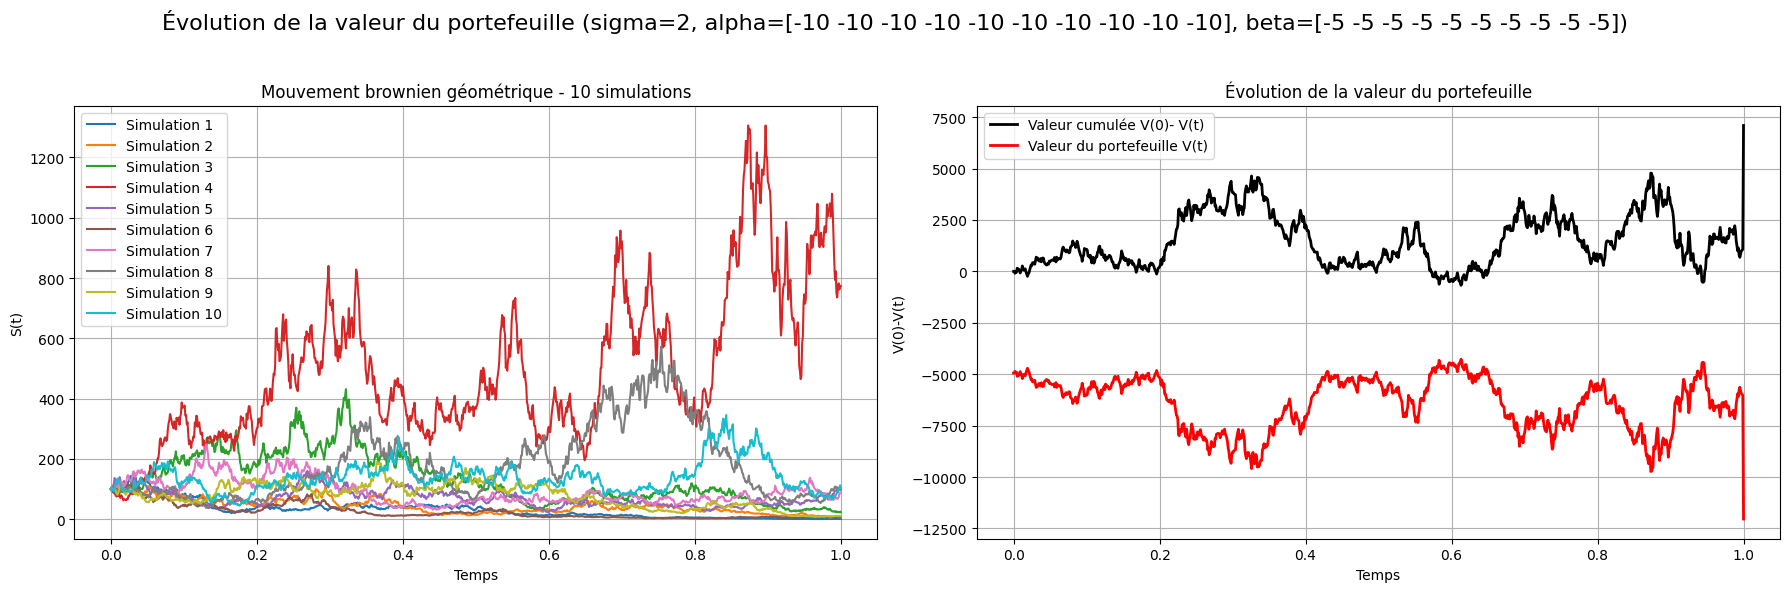

Running simulation for portfolio 3...


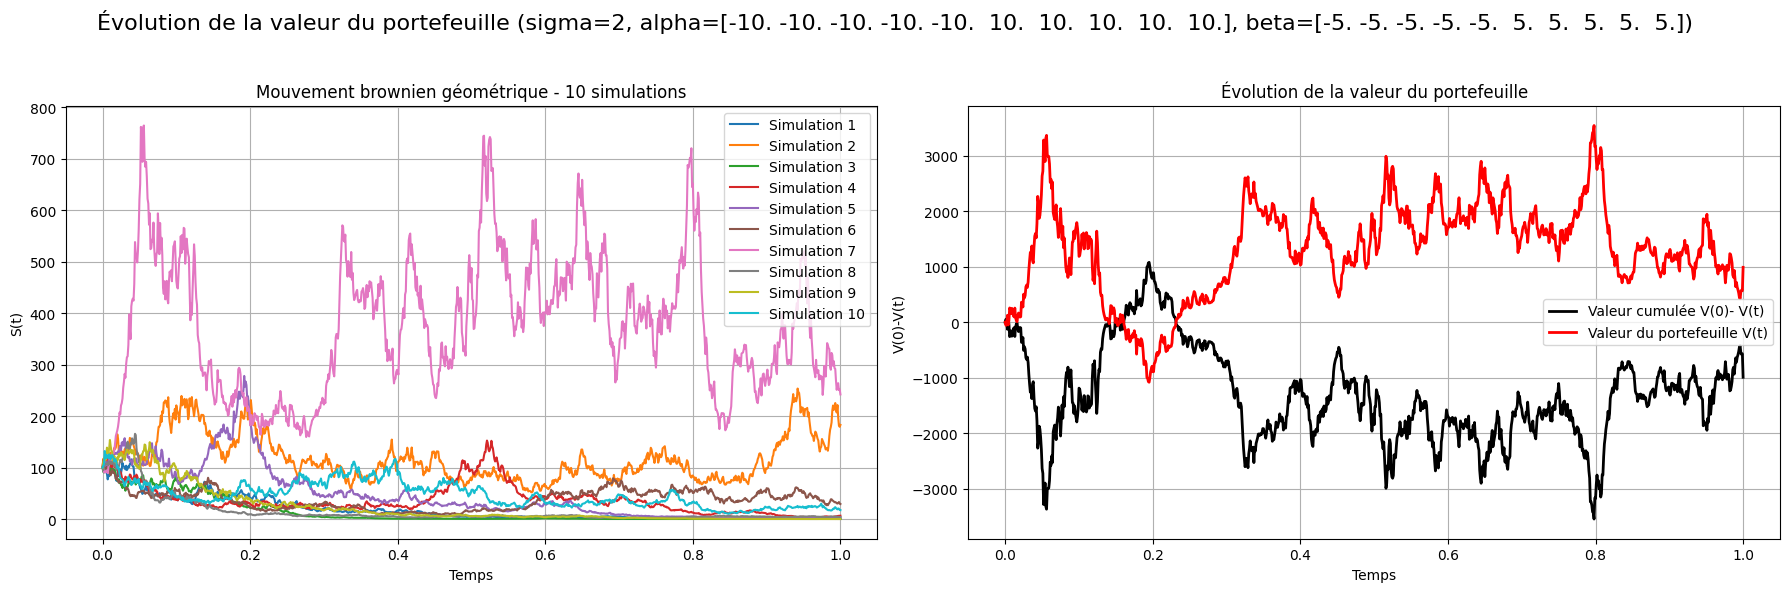

In [42]:
# Paramètres de simulation
S0 = 100      # Prix initial
K = S0        # Strike
sigma = 2     # Volatilité
T = 1         # Maturité
N = 1000      # Nombre de pas de temps
dt = T / N    # Pas de temps
I0 = 10       # Nombre de trajectoires

# Paramètres du portefeuille 1
alpha1 = np.full(I0, 10)
beta1 = np.full(I0, 5)

# Paramètres du portefeuille 2
alpha2 = np.full(I0, -10)
beta2 = np.full(I0, -5)

# Paramètres du portefeuille 2
alpha3 = np.zeros(I0)
beta3 = np.zeros(I0)

for i in range(I0) :
    if i <5 :
        alpha3[i], beta3[i] = -10, -5
    else :
        alpha3[i], beta3[i] = 10, 5

reproductivité(will)

print("Running simulation for portfolio 1...")
simulation(alpha= alpha1, beta= beta1, T= T, K= T, sigma=sigma, S0=S0, N=N, I0=I0)
print("Running simulation for portfolio 2...")
simulation(alpha= alpha2, beta= beta2, T= T, K= T, sigma=sigma, S0=S0, N=N, I0=I0)
print("Running simulation for portfolio 3...")
simulation(alpha= alpha3, beta= beta3, T= T, K= T, sigma=sigma, S0=S0, N=N, I0=I0)

## **Histogramme des valeurs du portefeuille et de la valeur cumulée**

Dans cette section, nous implémentons une fonction `calcul_histogramme` qui trace les histogrammes :

- des valeurs finales du portefeuille $ V(T) $,
- des valeurs cumulées $ V(0) - V(T) $,
- l'estimation de densité par noyau gaussien avec `gaussian_kde`des valeurs observées

In [43]:
def calcul_histogramme(alpha: np.ndarray, beta: np.ndarray, T: float, K: float, sigma: float, S0: float, N: int, I0: int, n_iter: int):
    t_grid = np.linspace(0, T, N + 1)
    dt = T / N
    V = []

    # Simulation Monte Carlo
    for _ in range(n_iter):
        S_paths = np.zeros((I0, N + 1))
        for i in range(I0):
            W = np.zeros(N + 1)
            W[1:] = np.cumsum(np.sqrt(dt) * np.random.randn(N))
            S_paths[i] = S0 * np.exp(-0.5 * sigma**2 * t_grid + sigma * W)
        S_T = S_paths[:, -1]
        V_T = valeur_portefeuille(alpha, beta, S_T, T, T, K, sigma)
        V.append(V_T)

    V = np.array(V)
    #V_cumul = V[0] - V if len(V) > 0 else np.array([])

    # Création du graphique
    fig, ax = plt.subplots(figsize=(12, 6))

    if len(V) > 1:
        kde = gaussian_kde(V)
        x = np.linspace(min(V), max(V), 1000)
        ax.hist(V, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7, label="Histogramme")
        ax.plot(x, kde(x), color='red', linewidth=2, label='Densité KDE')
        ax.set_title(f"Distribution des valeurs à maturité\nMoyenne: {np.mean(V):.2f}, Écart-type: {np.std(V):.2f}")
        ax.legend()

    ax.set_xlabel("Valeur du portefeuille")
    ax.set_ylabel("Densité de probabilité")
    ax.grid(True, linestyle='--', alpha=0.5)

    title = (f"Distribution des valeurs du portefeuille\n"
             f"Config: calls {alpha}, puts {beta} | σ={sigma} | {n_iter} simulations")
    plt.suptitle(title, fontsize=14, y=1.02)

    plt.tight_layout()
    plt.show()


### Mise en œuvre pour les trois portefeuilles présentés dans le sujet

Dans l'implémentation qui suit, nous avons choisi de fixer la volatilité à $\sigma = 0.5 $, comme indiqué ci-dessous :

```python
sigma = 0.5  # Volatilité choisie pour la simulation

Running simulation for portfolio 1...


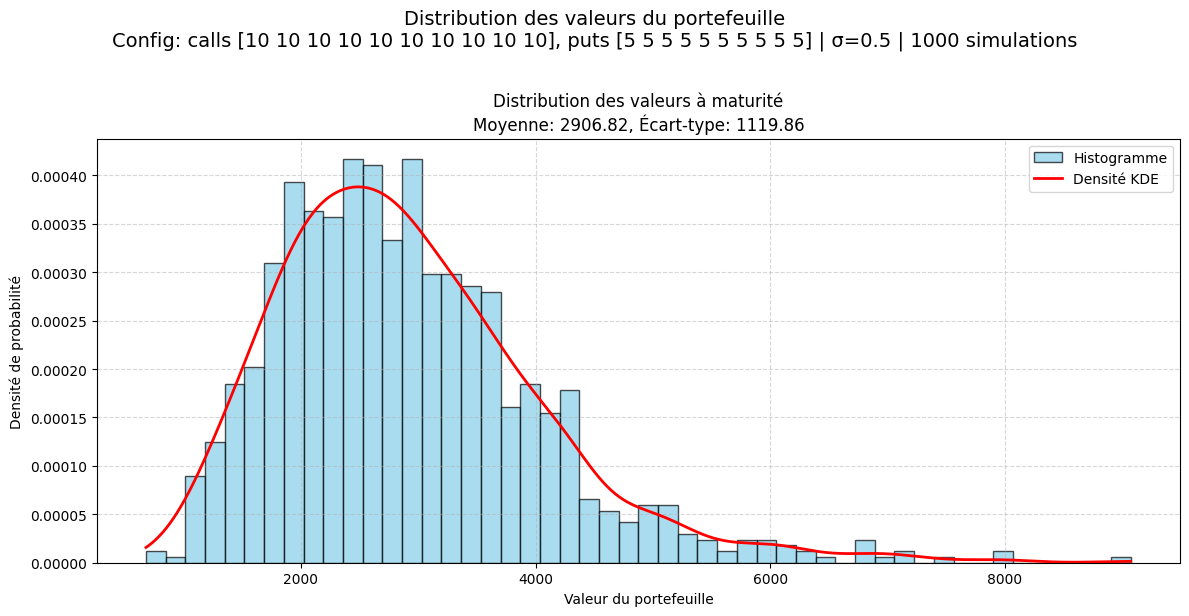

Running simulation for portfolio 2...


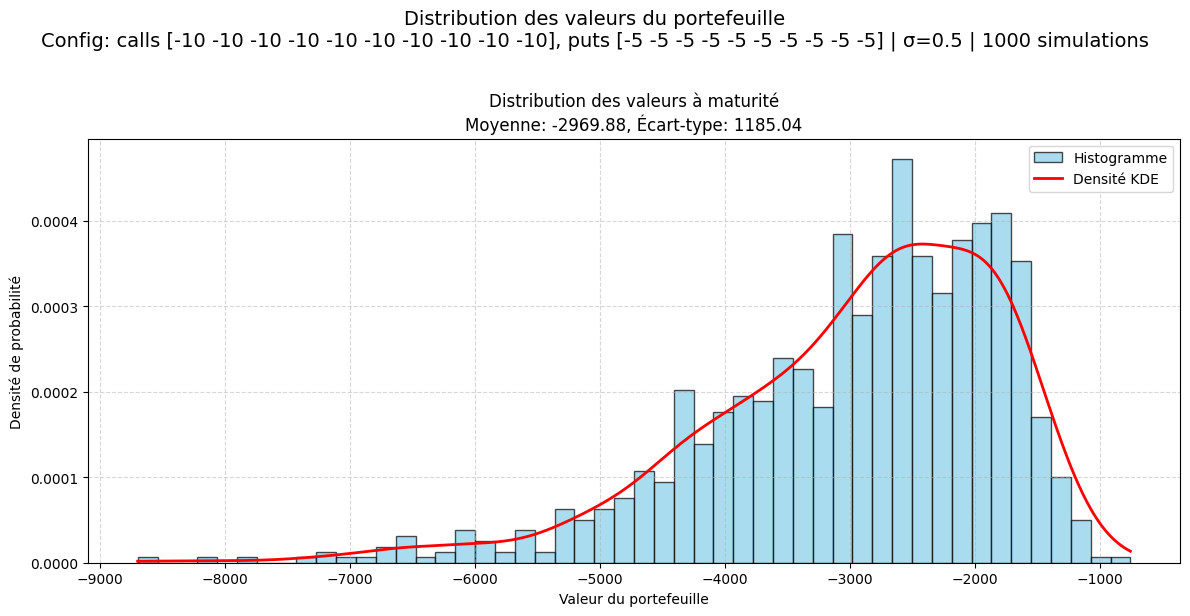

Running simulation for portfolio 3...


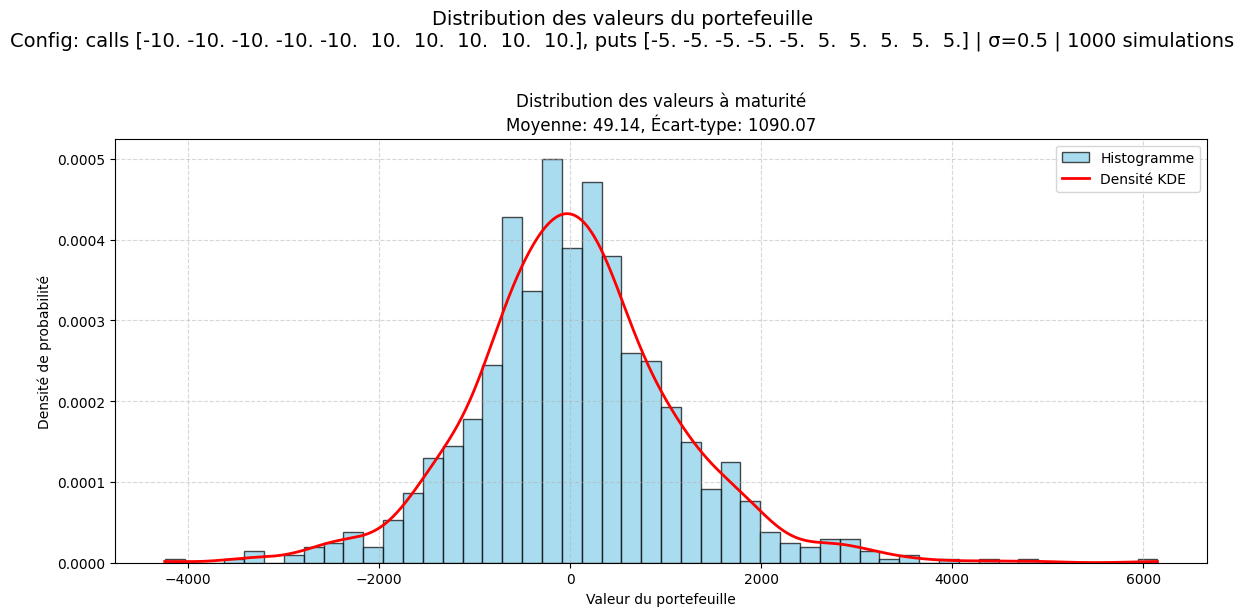

In [44]:
# Paramètres
S0 = 100      # Prix initial
K = S0        # Strike
sigma = 0.5     # Volatilité
T = 1         # Maturité
N = 1000      # Nombre de pas de temps
I0 = 10       # Nombre de trajectoires par simulation
n_iter = 1000  # Nombre de simulations
t_grid = np.linspace(0, T, N + 1)

# Paramètres du portefeuille 1
alpha1 = np.full(I0, 10)
beta1 = np.full(I0, 5)

# Paramètres du portefeuille 2
alpha2 = np.full(I0, -10)
beta2 = np.full(I0, -5)

# Paramètres du portefeuille 2
alpha3 = np.zeros(I0)
beta3 = np.zeros(I0)

for i in range(I0) :
    if i <5 :
        alpha3[i], beta3[i] = int(-10), int(-5)
    else :
        alpha3[i], beta3[i] = int(10), int(5)

reproductivité(will)

print("Running simulation for portfolio 1...")
calcul_histogramme(alpha= alpha1, beta= beta1, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
print("Running simulation for portfolio 2...")
calcul_histogramme(alpha= alpha2, beta= beta2, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
print("Running simulation for portfolio 3...")
calcul_histogramme(alpha= alpha3, beta= beta3, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)

## **Présentation du portefeuille test**

Running simulation for portfolio test...


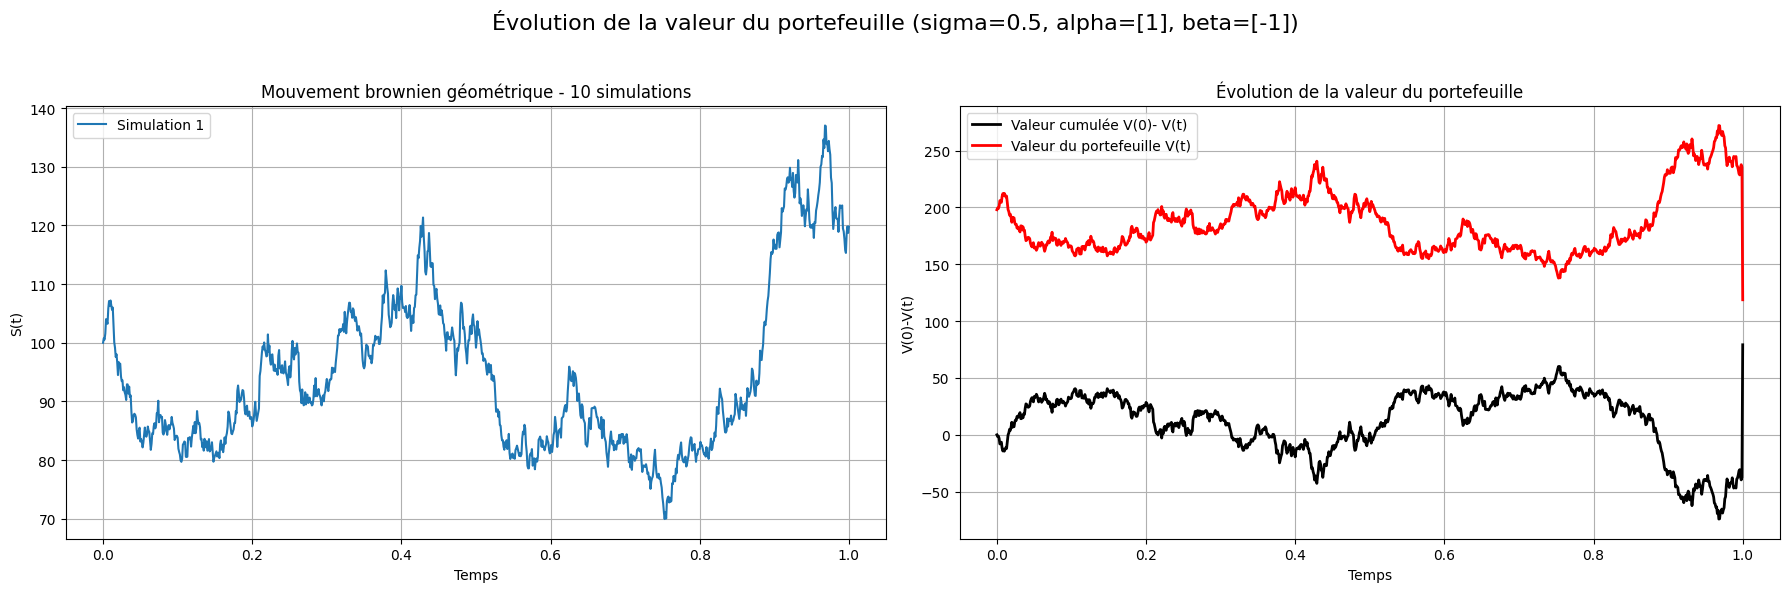

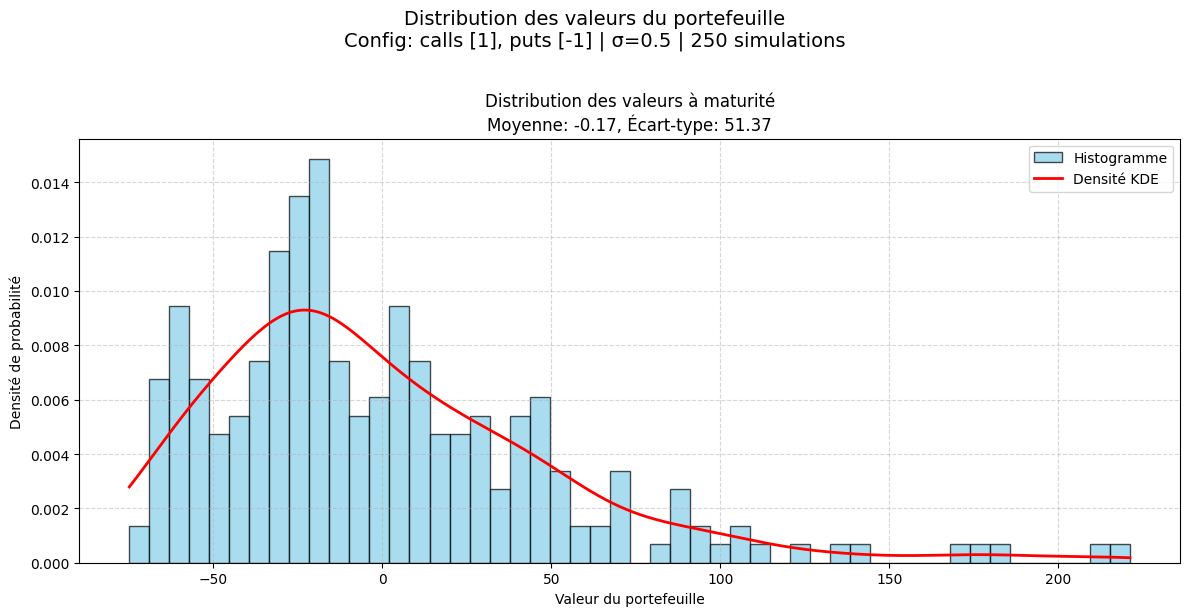

In [45]:
# Paramètres
S0 = 100
K = S0
sigma = 0.5
T = 1
N = 1000
I0 = 1
n_iter = 250
alpha = np.array([1])
beta = np.array([-1])
mu_values = np.linspace(1, 5, 50)  
alpha = np.array([1])
beta = np.array([-1])

reproductivité(will)

print("Running simulation for portfolio test...")
simulation(alpha= alpha, beta= beta, T= T, K= T, sigma=sigma, S0=S0, N=N, I0=I0)
calcul_histogramme(alpha= alpha, beta= beta, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)

# **Calcul des probabilités d'événements rares et des quantiles associés (Monté Carlo naïf)**




Nous faisons le choix de nous concentrer uniquement sur les probabilités de la forme $\mathbb{P}(V_T \geq q)$ ou $ \mathbb{P}(V_T \leq q) $, plutôt que sur des probabilités sur la valeur cumulée comme $ \mathbb{P}(V_0 - V_T \geq q) $ ou $ \mathbb{P}(V_0 - V_T \leq q) $. En effet, $ V_0 $ étant fixé, ces deux points de vue sont complètement équivalents.

Cela simplifie les calculs et permet de se concentrer sur l'évolution de la valeur du portefeuille à maturité $ V_T $, sans perte de généralité.

## Méthode de Monte carlo naif pour la probabilité

La méthode de Monte Carlo naïve est la forme la plus intuitive pour calculer la probabilité d'un événement rare.

Dans la suite, nous allons implémenter les fonctions suivantes :

1. **Fonction `sample`** : Cette fonction permet de faire des tirages sous la loi de $V_T$ . Bien que nous n'ayons pas directement accès à cette loi, nous pouvons au moins l'échantillonner en simulant des trajectoires pour le portefeuille.

2. **Fonction `MC_naif`** : Cette fonction estime la probabilité recherchée (à seuil $ q $ fixé) en utilisant la méthode de Monte Carlo naïve. Elle calcule la probabilité $\mathbb{P}(V_T \leq q)$ en effectuant des simulations et en comptant le nombre d'événements satisfaisant la condition $V_T \leq q $.


In [46]:
# Paramètres
S0 = 100      # Prix initial
K = S0        # Strike
sigma = 0.5     # Volatilité
T = 1         # Maturité
N = 1000      # Nombre de pas de temps
dt = T / N    # Pas de temps
I0 = 10       # Nombre de trajectoires par simulation
n_iter = 1000 # Nombre de simulations


# -----------------------------
# Génération d'un échantillon
# -----------------------------
def sample(alpha, beta, T, K, sigma, S0, N, I0):
    t_grid = np.linspace(0, T, N + 1)
    dt = T / N
    S_paths = np.zeros((I0, N + 1))
    for i in range(I0):
        W = np.zeros(N + 1)
        W[1:] = np.cumsum(np.sqrt(dt) * np.random.randn(N))
        S_paths[i] = S0 * np.exp(-0.5 * sigma**2 * t_grid + sigma * W)
    
    S_T = S_paths[:, -1]
    V_T = valeur_portefeuille(alpha, beta, S_T, T, T, K, sigma)
    return V_T


# -----------------------------
# Monte Carlo naïf
# -----------------------------
def MC_naif(alpha: np.ndarray, beta: np.ndarray, T: float, K: float, sigma: float, S0: float, N: int, I0: int, n_iter: int, seuil: float, type : str):

    # Liste pour stocker la valeur finale du portefeuille qui satisfont la condition
    V = []
    V_ret = []

    for iteration in range(n_iter):
        # Simulation des trajectoires de S_t
        V_T = sample(alpha=alpha, beta= beta, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0)
        V_ret.append(V_T)
        if type == "sup" and V_T >= seuil:
            V.append(V_T)
        if type == "inf" and V_T <= seuil:
            V.append(V_T)
    
    p_hat = len(V)/n_iter
    # Erreur standard (sous TCL)
    std_error = np.sqrt(p_hat * (1 - p_hat) / n_iter)
    
    # Intervalle de confiance à 95 %
    z = 1.96  # Quantile normal à 97.5 %
    lower = p_hat - z * std_error
    upper = p_hat + z * std_error
    signe = ">" if type =="sup" else "<"
    #print(f"La valeur de la probailité par MC_naif est P(V_T {signe} {seuil}) = {len(V)/n_iter}, IC(95%) = [{lower}, {upper}]")
    return p_hat, std_error, V_ret, lower, upper

### Mise en œuvre pour les trois portefeuilles présentés dans le sujet

1. Portefeuille 1 :  
Nous choisissons un seuil $q = 5000 $ et un autre à $ q = 10000 $. Nous voulons donc estimer $ \mathbb{P}(V_T \geq q) $ par la méthode de Monte Carlo naïve.

2. Portefeuille 2 :  
Nous choisissons un seuil $q = -2500 $ et un autre à $ q = 10000 $. Nous voulons donc estimer $ \mathbb{P}(V_T \geq q) $ par la méthode de Monte Carlo naïve.

3. Portefeuille 3 :  
Nous choisissons un seuil $q = 2500 $ et un autre à $ q = 10000 $. Nous voulons donc estimer $ \mathbb{P}(V_T \geq q) $ par la méthode de Monte Carlo naïve.

Les seuils ont été choisis de manière un peu heuristique en observant les histogrammes de la partie précédente. Pour chaque portefeuille, nous avons choisi deux seuils de manière à ce que :
- Le premier seuil soit associé à un événement qui **n'est pas rare**. La méthode de Monte Carlo naïve devrait donc être plus ou moins performante à ce niveau.
- Le second seuil soit tel qu'il **ne soit pas réalisé** dans les simulations de l'histogramme, et donc la méthode de Monte Carlo naïve devrait complètement échouer à retourner la probabilité. En effet, elle devrait renvoyer une probabilité de 0.

In [47]:
seuil1 = 5000
seuil2 = 10000

reproductivité(will)

print(f"Estimaton par MC naif de la probabilté pour le portefeuille 1 alpha = {alpha1}, beta = {beta1}, sigma = {sigma}...")
p_hat, std_error,_, lower, upper = MC_naif(alpha= alpha1, beta= beta1, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter, seuil= seuil1, type= "sup")
print(f"La valeur de la probailité par MC_naif est P(V_T >= {seuil1}) = {p_hat}, IC(95%) = [{lower}, {upper}]")
p_hat, std_error,_, lower, upper = MC_naif(alpha= alpha1, beta= beta1, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter, seuil= seuil2, type= "sup")
print(f"La valeur de la probailité par MC_naif est P(V_T >= {seuil2}) = {p_hat}, IC(95%) = [{lower}, {upper}]")

print(f"\nEstimaton par MC naif de la probabilté pour le portefeuille 2 alpha = {alpha2}, beta = {beta2}, sigma = {sigma}...")
p_hat, std_error,_, lower, upper = MC_naif(alpha= alpha2, beta= beta2, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter, seuil= -seuil1/2, type= "inf")
print(f"La valeur de la probailité par MC_naif est P(V_T <= {-seuil1/2}) = {p_hat}, IC(95%) = [{lower}, {upper}]")
p_hat, std_error,_, lower, upper = MC_naif(alpha= alpha2, beta= beta2, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter, seuil= -seuil2, type= "inf")
print(f"La valeur de la probailité par MC_naif est P(V_T <= {-seuil2}) = {p_hat}, IC(95%) = [{lower}, {upper}]")

print(f"\nEstimaton par MC naif de la probabilté pour le portefeuille 3 alpha = {alpha3}, beta = {beta3}, sigma = {sigma}...")
p_hat, std_error,_, lower, upper = MC_naif(alpha= alpha3, beta= beta3, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter, seuil= seuil1/2, type= "sup")
print(f"La valeur de la probailité par MC_naif est P(V_T >= {seuil1/2}) = {p_hat}, IC(95%) = [{lower}, {upper}]")
p_hat, std_error,_, lower, upper = MC_naif(alpha= alpha3, beta= beta3, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter, seuil= 10 * seuil2, type= "sup")
print(f"La valeur de la probailité par MC_naif est P(V_T >= {10 * seuil2 }) = {p_hat}, IC(95%) = [{lower}, {upper}]")

Estimaton par MC naif de la probabilté pour le portefeuille 1 alpha = [10 10 10 10 10 10 10 10 10 10], beta = [5 5 5 5 5 5 5 5 5 5], sigma = 0.5...
La valeur de la probailité par MC_naif est P(V_T >= 5000) = 0.049, IC(95%) = [0.03562036179861354, 0.062379638201386464]
La valeur de la probailité par MC_naif est P(V_T >= 10000) = 0.0, IC(95%) = [0.0, 0.0]

Estimaton par MC naif de la probabilté pour le portefeuille 2 alpha = [-10 -10 -10 -10 -10 -10 -10 -10 -10 -10], beta = [-5 -5 -5 -5 -5 -5 -5 -5 -5 -5], sigma = 0.5...
La valeur de la probailité par MC_naif est P(V_T <= -2500.0) = 0.59, IC(95%) = [0.5595158559247598, 0.6204841440752401]
La valeur de la probailité par MC_naif est P(V_T <= -10000) = 0.0, IC(95%) = [0.0, 0.0]

Estimaton par MC naif de la probabilté pour le portefeuille 3 alpha = [-10. -10. -10. -10. -10.  10.  10.  10.  10.  10.], beta = [-5. -5. -5. -5. -5.  5.  5.  5.  5.  5.], sigma = 0.5...
La valeur de la probailité par MC_naif est P(V_T >= 2500.0) = 0.02, IC(95%) = 

## Détermination de quantile 

Nous allons implémenter une méthode empirique pour le calcul du quantile d’ordre $\alpha $, en nous appuyant sur l’estimation de la fonction de répartition.

Même si la loi de $V_T $ n’est pas connue explicitement, nous pouvons obtenir des réalisations indépendantes de cette variable via une fonction `sample` que nous avons définie précédemment.

**CONSTRUCTION DE L'INTERVALLE DE CONFIANCE**

Nous avons prouvé dans le TD 2 que $ \forall u \in ]0,1[$; en posant
$$  u^-_n := u  - 1.96  \,  \frac{\sqrt{u (1-u)}}{\sqrt{n}}, \qquad u^+_n := u  + 1.96 \,  \frac{\sqrt{u (1-u)}}{\sqrt{n}}.$$ 
$[\hat{q}_n(u_n^-),\hat{q}_n(u_n^+)[$ est un intervalle de confiance asymptotique de probabilité de couverture  $95\%$ pour $q(u)$.

### Implémentation des fonctions

Dans la suite, nous allons implémenter trois fonctions :

1. Une fonction `mult_sample`, qui est semblable à la fonction `sample`, mais permet de générer un échantillon de taille `n_iter`.

2. Une fonction `fonction_repartition_empirique`, qui construit et trace la fonction de répartition empirique à partir d’un échantillon simulé.

3. Une fonction `quantile_empirique`, qui :
   - estime la valeur d’un quantile d’ordre donné,
   - détermine les bornes de intervalle de confiance asymptotique à 95 % pour ce quantile,
   - renvoie également les plus petites et les plus grandes valeurs de l’échantillon utilisé pour l’estimation.

In [48]:
def mult_sample(alpha: np.ndarray, beta: np.ndarray, T: float, K: float, sigma: float, S0: float, N: int, I0: int, n_iter: int):
    """
    Renvoie un échantillon de n_iter réalisations indépendantes de V_T
    """
    t_grid = np.linspace(0, T, N + 1)
    samples = []

    for _ in range(n_iter):
        samples.append(sample(alpha=alpha, beta= beta, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0))

    return np.array(samples)

def fonction_repartition_empirique(alpha: np.ndarray, beta: np.ndarray, T: float, K: float, sigma: float,
                                   S0: float, N: int, I0: int, n_iter: int):
    """
    Génère les échantillons avec mult_sample et trace la fonction de répartition empirique
    """
    data = mult_sample(alpha, beta, T, K, sigma, S0, N, I0, n_iter)
    data_sorted = np.sort(data)
    n = len(data_sorted)
    y = np.arange(1, n + 1) / n
    fig, ax = plt.subplots(figsize=(8, 4), facecolor='white')
    
    plt.step(data_sorted, y, where="post", 
             label="Fonction de répartition empirique", 
             color="#4361ee", linewidth=2.5, alpha=0.9)
    
    ax.fill_between(data_sorted, 0, y, step="post", 
                    color="red", alpha=0.1)
    
    ax.set_xlabel("Valeur de $V_T$", fontsize=14, labelpad=10)
    ax.set_ylabel(r"$\hat{F}_n(x)$", fontsize=14, labelpad=10)
    
    title = (
        f"Fonction de répartition empirique de $V_T$\n"
        f"Config: α={alpha} \n β={beta} "
    )
    ax.set_title(title, fontsize=15, pad=20)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.7)
    ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

    legend = ax.legend(frameon=True, fontsize=12, 
                       borderpad=1, handlelength=1.5)
    legend.get_frame().set_edgecolor('#d3d3d3')
    legend.get_frame().set_facecolor('white')
    
    plt.tight_layout()
    
    # Affichage
    plt.show()

def quantile_empirique(alpha_quantile: float, alpha: np.ndarray, beta: np.ndarray, T: float, K: float,
                       sigma: float, S0: float, N: int, I0: int, n_iter: int):
    """
    Estime le quantile empirique d'ordre alpha_quantile à partir de réalisations générées
    """
    data = mult_sample(alpha, beta, T, K, sigma, S0, N, I0, n_iter)
    sorted_data = np.sort(data)
    n = len(sorted_data)
    index = int(np.ceil(alpha_quantile * n)) - 1  

    # Borne inférieure et supérieure du niveau asymptotique
    u_n_minus = alpha_quantile - 1.96 * np.sqrt(alpha_quantile * (1 - alpha_quantile) / n)
    u_n_plus  = alpha_quantile + 1.96 * np.sqrt(alpha_quantile * (1 - alpha_quantile) / n)

    u_n_minus = max(0.0, u_n_minus)  
    u_n_plus = min(1.0, u_n_plus)

    index_minus = int(np.ceil(u_n_minus * n)) - 1
    index_plus = int(np.ceil(u_n_plus * n)) - 1

    lower_bound = sorted_data[max(0, index_minus)]
    upper_bound = sorted_data[min(n - 1, index_plus)]

    min_val= sorted_data[0]
    max_val = sorted_data[-1]

    return sorted_data[index], lower_bound, upper_bound, min_val, max_val

### Mise en œuvre pour les trois portefeuilles présentés dans le sujet

Nous choisissons les valeurs suivantes pour les niveaux de quantile : $\alpha_1 = 0{,}6$ et $\alpha_2 = 10^{-4}$ pour les trois configurations de portefeuilles.

Ces valeurs sont choisies de sorte que :

1. $\alpha_1$ soit une valeur raisonnable, proche de $0.5$. La méthode naïve devrait pouvoir donner une estimation correcte du quantile associé, ainsi qu’un intervalle de confiance pertinent.

2. $\alpha_2$ soit une valeur très faible, correspondant à un événement rare. Dans ce cas, la méthode naïve développée ici devrait échouer à estimer correctement le quantile. L’intuition est qu’elle renverra simplement le plus petit élément observé dans l’échantillon, avec un intervalle de confiance qui, de la maniere dont il a été contruit $([a ,b[)$,sera vide.

Running simulation for portfolio 1...


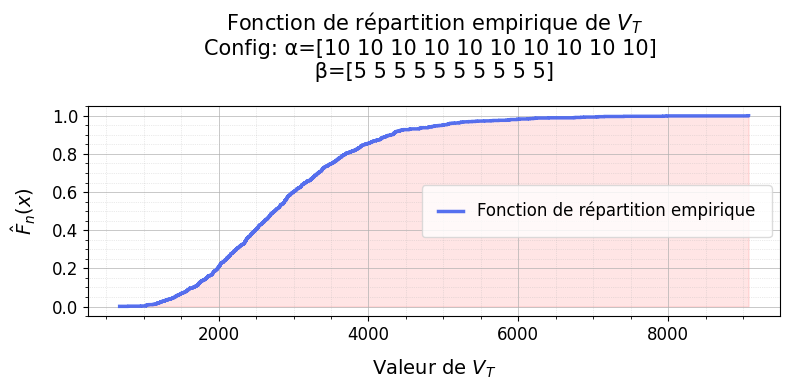

Estimation  du quantile empirique pour alpha = 0.6 : 3027.1525555124826 , IC(95%) = [2951.158123201477, 3111.8030576749584[
Estimation  du quantile empirique pour alpha = 0.0001 : 794.450431803013, IC(95%) = [794.450431803013, 794.450431803013[, 
Plus petite valeur observée : 794.450431803013

Running simulation for portfolio 2...


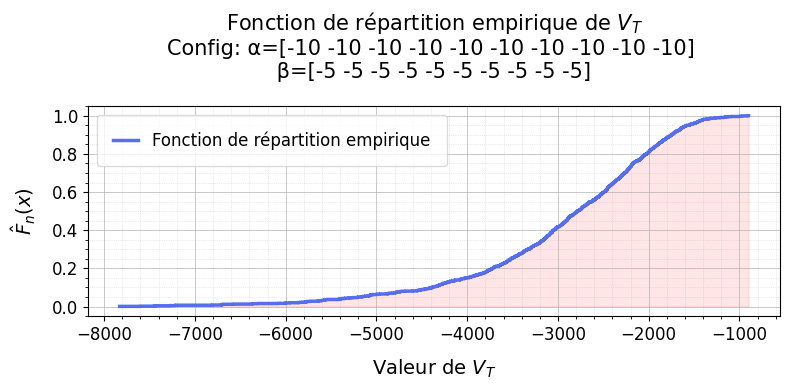

Estimation  du quantile empirique pour alpha = 0.6 : -2501.8210350264767, IC(95%) = [-2573.1816578562257, -2401.175543528668[
Estimation  du quantile empirique pour alpha = 0.0001 : -13929.098664881196, IC(95%) = [-13929.098664881196, -13929.098664881196[, 
Plus petite valeur observée : -13929.098664881196

Running simulation for portfolio 3...


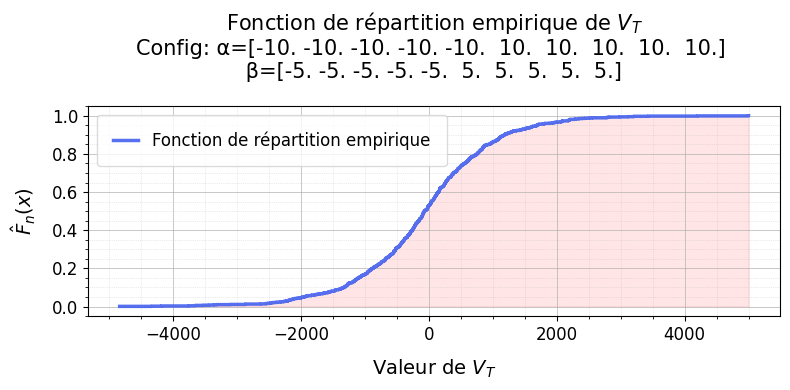

Estimation  du quantile empirique pour alpha = 0.6 : 230.43655362393312, IC(95%) = [169.22783826561096, 291.0864131970065[
Estimation  du quantile empirique pour alpha = 0.0001 : -7126.817968398436, IC(95%) = [-7126.817968398436, -7126.817968398436[, 
Plus petite valeur observée : -7126.817968398436


In [49]:
# Paramètres
S0 = 100      # Prix initial
K = S0        # Strike
sigma = 0.5     # Volatilité
T = 1         # Maturité
N = 1000      # Nombre de pas de temps
dt = T / N    # Pas de temps
I0 = 10       # Nombre de trajectoires par simulation
n_iter = 1000 # Nombre de simulations

alpha_1 = 0.6
alpha_2 = 1.e-4

reproductivité(will)

print("Running simulation for portfolio 1...")
fonction_repartition_empirique(alpha= alpha1, beta= beta1, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
q1, l1, l2, min_val, max_val= quantile_empirique (alpha_quantile= alpha_1, alpha= alpha1, beta= beta1, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
print(f"Estimation  du quantile empirique pour alpha = {alpha_1} : {q1} , IC(95%) = [{l1}, {l2}[")
q2, l1, l2, min_val, max_val= quantile_empirique (alpha_quantile= alpha_2, alpha= alpha1, beta= beta1, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
print(f"Estimation  du quantile empirique pour alpha = {alpha_2} : {q2}, IC(95%) = [{l1}, {l2}[, \nPlus petite valeur observée : {min_val}")

print("\nRunning simulation for portfolio 2...")
fonction_repartition_empirique(alpha= alpha2, beta= beta2, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
q1, l1, l2, min_val, max_val= quantile_empirique (alpha_quantile= alpha_1, alpha= alpha2, beta= beta2, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
print(f"Estimation  du quantile empirique pour alpha = {alpha_1} : {q1}, IC(95%) = [{l1}, {l2}[")
q2, l1, l2, min_val, max_val= quantile_empirique (alpha_quantile= alpha_2, alpha= alpha2, beta= beta2, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
print(f"Estimation  du quantile empirique pour alpha = {alpha_2} : {q2}, IC(95%) = [{l1}, {l2}[, \nPlus petite valeur observée : {min_val}")

print("\nRunning simulation for portfolio 3...")
fonction_repartition_empirique(alpha= alpha3, beta= beta3, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
q1, l1, l2, min_val, max_val= quantile_empirique (alpha_quantile= alpha_1, alpha= alpha3, beta= beta3, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
print(f"Estimation  du quantile empirique pour alpha = {alpha_1} : {q1}, IC(95%) = [{l1}, {l2}[")
q2, l1, l2, min_val, max_val= quantile_empirique (alpha_quantile= alpha_2, alpha= alpha3, beta= beta3, T= T, K= K, sigma= sigma, S0= S0, N= N, I0= I0, n_iter= n_iter)
print(f"Estimation  du quantile empirique pour alpha = {alpha_2} : {q2}, IC(95%) = [{l1}, {l2}[, \nPlus petite valeur observée : {min_val}")

# Methode d'échantillonage d'importance

Nous avons vu au travers des précédentes simulations que la méthode de Monte Carlo dite "naïve", bien qu’intuitive, est très mal adaptée à l’estimation de probabilités ou de quantiles associés à des événements rares. Nous allons donc, dans cette partie, implémenter les méthodes d’échantillonnage d’importance.

L’idée générale de la méthode est la suivante :

Supposons que nous voulons calculer :
$$
\mathbb{E}\left[ h(X) \right] = \int h(x) \, \nu(x)\, \mathrm{d}x
$$
où $X$ est une variable aléatoire de loi $\nu$.

La méthode de Monte Carlo naïve consisterait à tirer un échantillon $(X_k)$ tel que $X_k \stackrel{i.i.d.}{\sim} \nu$, et à estimer l'espérance par :
$$
\hat{\mu}_n = \frac{1}{n} \sum_{k=1}^{n} h(X_k).
$$
Mais si la fonction $h$ est non nulle uniquement sur un ensemble de très faible probabilité sous la loi $\nu$, alors très peu (voire aucun) des $X_k$ générés ne contribueront à la somme, ce qui rend l’estimation inefficace.

Pour contourner ce problème, on utilise une **loi de changement de mesure** $\tilde{\nu}$, dite **loi d’importance**, plus concentrée sur les régions où $h$ est significatif. On réécrit alors l'espérance comme :
$$
\mathbb{E}_{\nu}[h(X)] = \int h(x) \frac{\nu(x)}{\tilde{\nu}(x)} \tilde{\nu}(x)\, \mathrm{d}x = \mathbb{E}_{\tilde{\nu}} \left[ h(X) \frac{\nu(X)}{\tilde{\nu}(X)} \right].
$$

On peut alors estimer cette nouvelle espérance par :
$$
\hat{\mu}_n^{\text{IS}} = \frac{1}{n} \sum_{k=1}^{n} h(X_k) \frac{\nu(X_k)}{\tilde{\nu}(X_k)}, \quad \text{avec } X_k \stackrel{i.i.d.}{\sim} \tilde{\nu}.
$$

Tout l'enjeu maintenant reside sur le choix de la nouvelle loi d'importance $\tilde{\nu}$


## Recherche du changement de loi



Dans la suite, nous allons implémenter une fonction `simulate_portfolio_values` qui trace l’évolution de $ \mathbb{E}_{\mathcal{N}(\mu t, t)}(V_T) $ en fonction de $ \mu $, ce qui nous permettra de choisir une valeur de $ \mu $ adaptée.


Running simulation for portfolio 1...


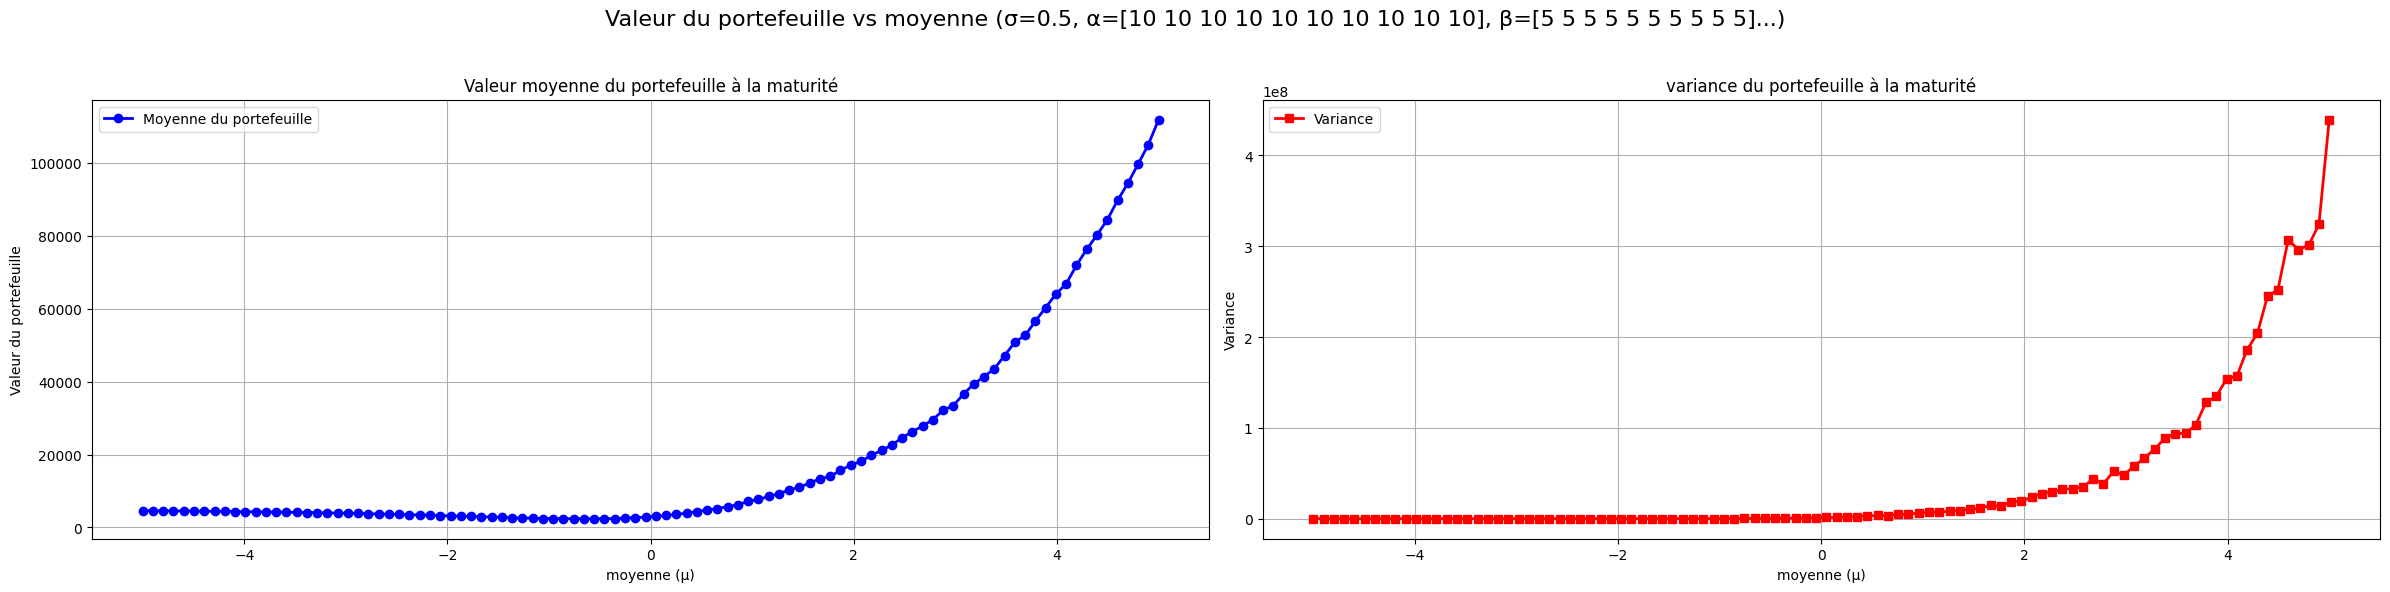

Running simulation for portfolio 2...


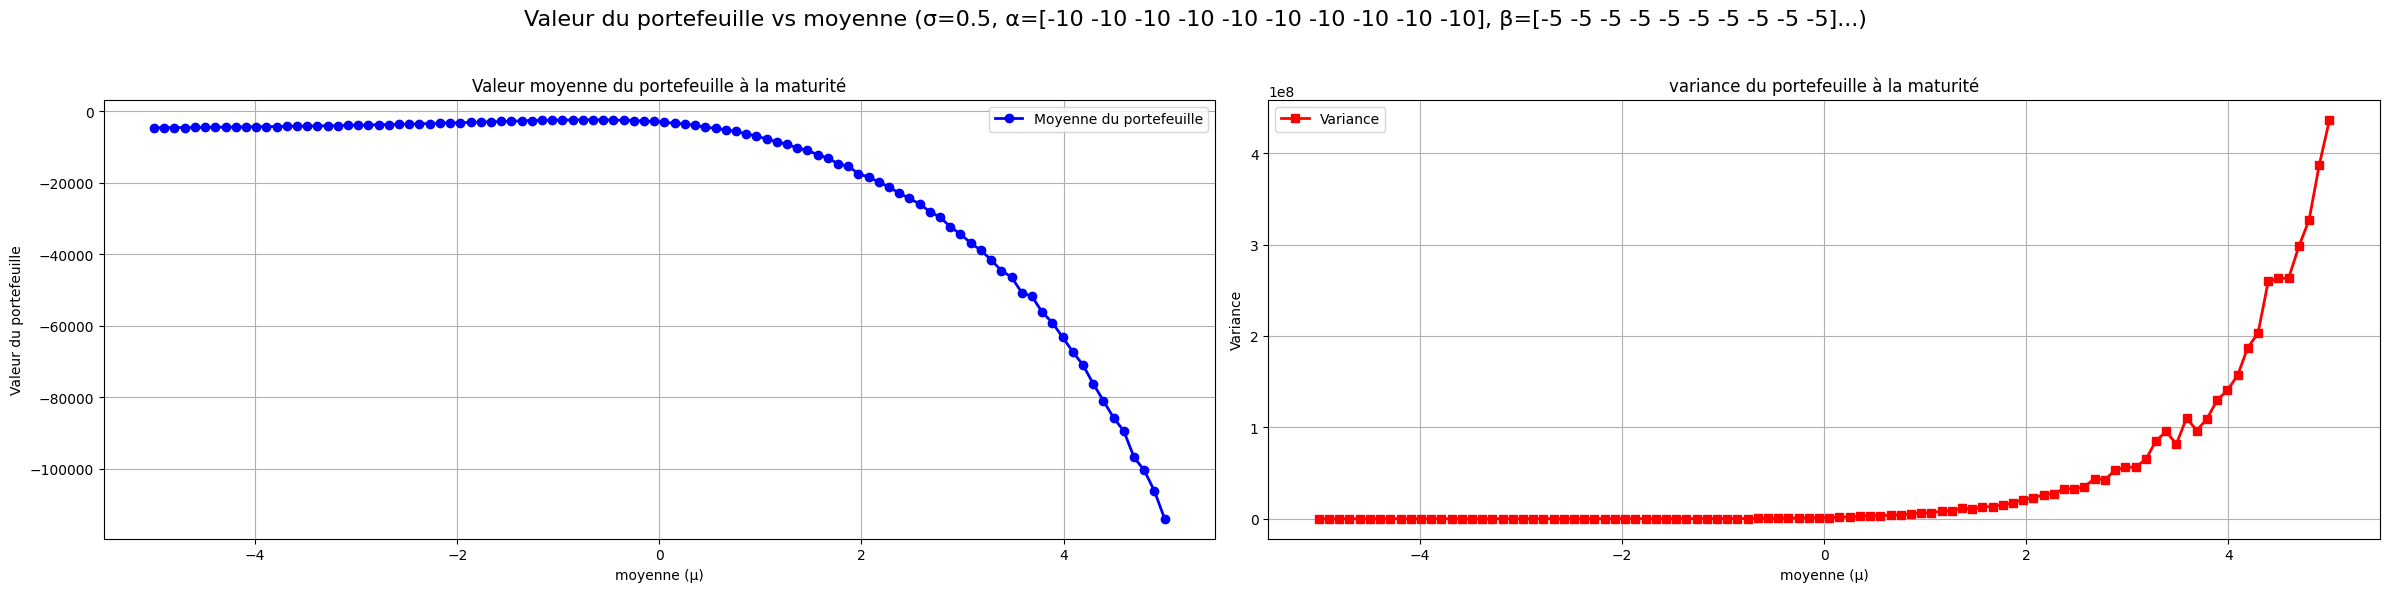

Running simulation for portfolio 3...


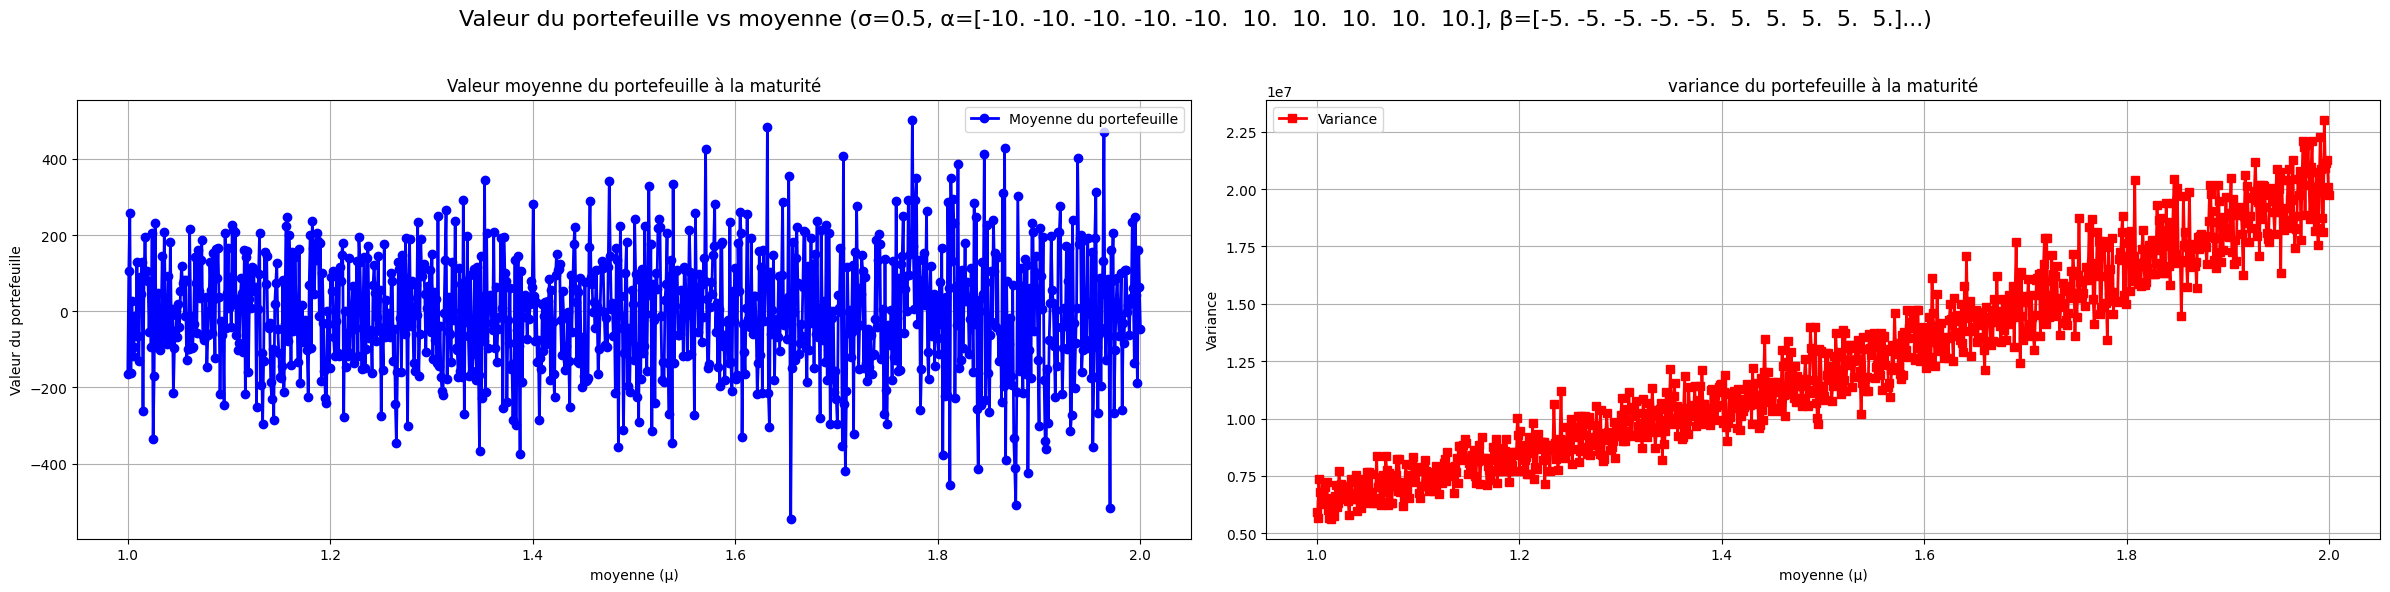

In [53]:
def simulate_portfolio_values(mu_values, S0, K, sigma, T, N, dt, I0, n_iter, alpha, beta, seuil=None):
    moyennes = np.zeros(len(mu_values))
    variances = np.zeros(len(mu_values))

    sqrt_dt = np.sqrt(dt)
    t_grid = np.linspace(0, T, N + 1)

    for idx, mu in enumerate(mu_values):
        V_T_all = np.zeros(n_iter)

        for iter in range(n_iter):
            # Simule I0 trajectoires
            Z = np.random.randn(I0, N)
            W = np.zeros((I0, N + 1))
            W[:, 1:] = np.cumsum(mu*dt + sqrt_dt * Z, axis=1)

            # Calcule les trajectoires de S_t
            exponent = ( - 0.5 * sigma**2) * t_grid + sigma * W
            S_paths = S0 * np.exp(exponent)
            S_T = S_paths[:, -1]  

            # Calcule la valeur du portefeuille
            V_T_values = valeur_portefeuille(alpha=alpha, beta=beta, S_t=S_T, t=T, T=T, K=K, sigma=sigma)
            V_T_all[iter] = np.mean(V_T_values)

        # Moyenne et variance sur les n_iter simulations
        moyennes[idx] = np.mean(V_T_all)
        variances[idx] = np.var(V_T_all)

    if seuil is not None:
        # Trouve l'indice dont la moyenne est la plus proche du seuil
        idx_proche = np.argmin(np.abs(moyennes - seuil))
        return idx_proche, moyennes, variances
    else:
        return moyennes, variances



def plot_results(mu_values, moyennes, variances, alpha, beta, sigma, test= False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

    ax1.plot(mu_values, moyennes, 'b-', linewidth=2, marker='o', label='Moyenne du portefeuille')
    ax1.set_title("Valeur moyenne du portefeuille à la maturité")
    ax1.set_xlabel("moyenne (μ)")
    ax1.set_ylabel("Valeur du portefeuille")
    ax1.grid(True)
    ax1.legend()

    ax2.plot(mu_values, variances, 'r-', linewidth=2, marker='s', label='Variance')
    ax2.set_title("variance du portefeuille à la maturité")
    ax2.set_xlabel("moyenne (μ)")
    ax2.set_ylabel("Variance")
    ax2.grid(True)
    ax2.legend()

    fig.suptitle(f"Valeur du portefeuille vs moyenne (σ={sigma}, α={alpha}, β={beta}...)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Parameters
S0 = 100
K = S0
sigma = 0.5
T = 1
N = 500  
dt = T / N
I0 = 10
n_iter = 500  # nombre d'itération
mu_values = np.linspace(-5, 5, 100) 
mu_values1 = np.linspace(1, 2, 1000)  

# portefeuille
alpha1 = np.full(I0, 10)
beta1 = np.full(I0, 5)

alpha2 = np.full(I0, -10)
beta2 = np.full(I0, -5)

alpha3 = np.zeros(I0)
beta3 = np.zeros(I0)
for i in range(I0):
    alpha3[i], beta3[i] = (-10, -5) if i < 5 else (10, 5)

reproductivité(will)

# Run simulations
print("Running simulation for portfolio 1...")
moyennes1, variances1 = simulate_portfolio_values(mu_values, S0, K, sigma, T, N, dt, I0, n_iter, alpha1, beta1)
plot_results(mu_values, moyennes1, variances1, alpha1, beta1, sigma)

print("Running simulation for portfolio 2...")
moyennes2, variances2 = simulate_portfolio_values(mu_values, S0, K, sigma, T, N, dt, I0, n_iter, alpha2, beta2)
plot_results(mu_values, moyennes2, variances2, alpha2, beta2, sigma)

print("Running simulation for portfolio 3...")
moyennes3, variances3 = simulate_portfolio_values(mu_values1, S0, K, sigma, T, N, dt, I0, n_iter, alpha3, beta3)
plot_results(mu_values1, moyennes3, variances3, alpha3, beta3, sigma)

## Calcul des probabilités des évènements rares par échantillonage d'importance 

Nous implémentons ici les méthodes de IS par changement `importance_sampling_probability` de drift et par tranformation d'Esscher `importance_sampling_esscher` 

In [54]:

def valeur_portefeuille_bis(alpha, beta, S_t, t, T, K, sigma):
    """
    Calcule la valeur d'un portefeuille d'options.
    
    Parameters:
    - alpha: array de taille (I0,), coefficients des calls
    - beta: array de taille (I0,), coefficients des puts
    - S_t: array de taille (n_iter, I0), prix des actifs à t
    - t: temps actuel
    - T: maturité
    - K: prix d'exercice (scalaire ou array de taille I0)
    - sigma: volatilité (scalaire ou array de taille I0)
    
    Returns:
    - Valeur du portefeuille (array de taille n_iter)
    """
    if t == T:
        calls = np.maximum(S_t - K, 0)  
        puts = np.maximum(K - S_t, 0)   
        return np.sum(alpha * calls + beta * puts, axis=1)  
    
    tau = T - t
    d1 = (np.log(S_t / K) + (sigma**2 / 2) * tau) / (sigma * np.sqrt(tau))  
    d2 = d1 - sigma * np.sqrt(tau)  
    calls = S_t * stats.norm.cdf(d1) - K * stats.norm.cdf(d2)  
    puts = K * stats.norm.cdf(-d2) - S_t * stats.norm.cdf(-d1)  
    return np.sum(alpha * calls + beta * puts, axis=1)  

# Échantillonnage d'importance avec drift
def importance_sampling_probability(alpha, beta, T, K, sigma, S0, N, I0, n_iter, seuil, mu, type):
    dt = T / N
    sqrt_dt = np.sqrt(dt)
    t_grid = np.linspace(0, T, N + 1)
    
    V_T_values = np.zeros(n_iter)
    weights = np.zeros(n_iter)
    
    # Génération des trajectoires
    randoms = np.random.randn(n_iter, I0, N)  
    W = np.zeros((n_iter, I0, N + 1))  
    W[:, :, 1:] = np.cumsum(mu * dt + sqrt_dt * randoms, axis=2)  
    
    # Calcul des prix des actifs
    drift = (- 0.5 * sigma**2) * t_grid  
    S_paths = S0 * np.exp(drift + sigma * W)  
    S_T = S_paths[:, :, -1]  
    
    # Valeur du portefeuille
    V_T_values = valeur_portefeuille_bis(alpha, beta, S_T, T, T, K, sigma)  
    
    # Calcul des poids
    W_T = (np.log(S_T / S0) + 0.5 * sigma**2 * T - sigma * mu * T) / sigma  
    log_weights = -mu * W_T - 0.5 * mu**2 * T  
    total_log_weights = np.sum(log_weights, axis=1)  
    weights = np.exp(total_log_weights)  
    
    # Estimation de la probabilité
    indicators = (V_T_values > seuil).astype(float) if type == "sup" else (V_T_values < seuil).astype(float)
    p_hat = np.mean(indicators * weights)
    var_hat = np.var(indicators * weights) / n_iter
    
    return p_hat, var_hat, V_T_values, weights

# Échantillonnage d'importance avec transformation d'Esscher
def importance_sampling_esscher(alpha, beta, T, K, sigma, S0, N, I0, n_iter, seuil, theta, type):
    """
    Échantillonnage d'importance avec transformation d'Esscher.
    
    Parameters:
    - theta: paramètre Esscher 
    """
    dt = T / N
    sqrt_dt = np.sqrt(dt)
    t_grid = np.linspace(0, T, N + 1)
    
    V_T_values = np.zeros(n_iter)
    weights = np.zeros(n_iter)
    
    randoms = np.random.randn(n_iter, I0, N)
    W = np.zeros((n_iter, I0, N + 1))
    W[:, :, 1:] = np.cumsum(sqrt_dt * randoms, axis=2)
    
    drift = (theta * sigma**2 - 0.5 * sigma**2) * t_grid
    S_paths = S0 * np.exp(drift + sigma * W)
    S_T = S_paths[:, :, -1]
    
    V_T_values = valeur_portefeuille_bis(alpha, beta, S_T, T, T, K, sigma)
    
    W_T = (np.log(S_T / S0) + 0.5 * (sigma **2 - theta * sigma**2) * T) 
    log_weights = -theta * W_T 
    total_log_weights = np.sum(log_weights, axis=1)
    weights = np.exp(total_log_weights)
    
    indicators = (V_T_values > seuil).astype(float) if type == "sup" else (V_T_values < seuil).astype(float)
    p_hat = np.mean(indicators * weights)
    var_hat = np.var(indicators * weights) / n_iter
    
    return p_hat, var_hat, V_T_values, weights

## Test sur le portefeuille jouet

On commence par chercher le changement de loi pour la transformer pour Esscher ie le parametre $\mu_{opt}$ tel que 
$$
\mathbb{E}_\mu (V_T) = \text{seuil}
$$ 
On trace ci dessous pour le portefeuille  test
$$
\mathbb{E}_\mu (V_T)= f(\mu)
$$

Running simulation for test...


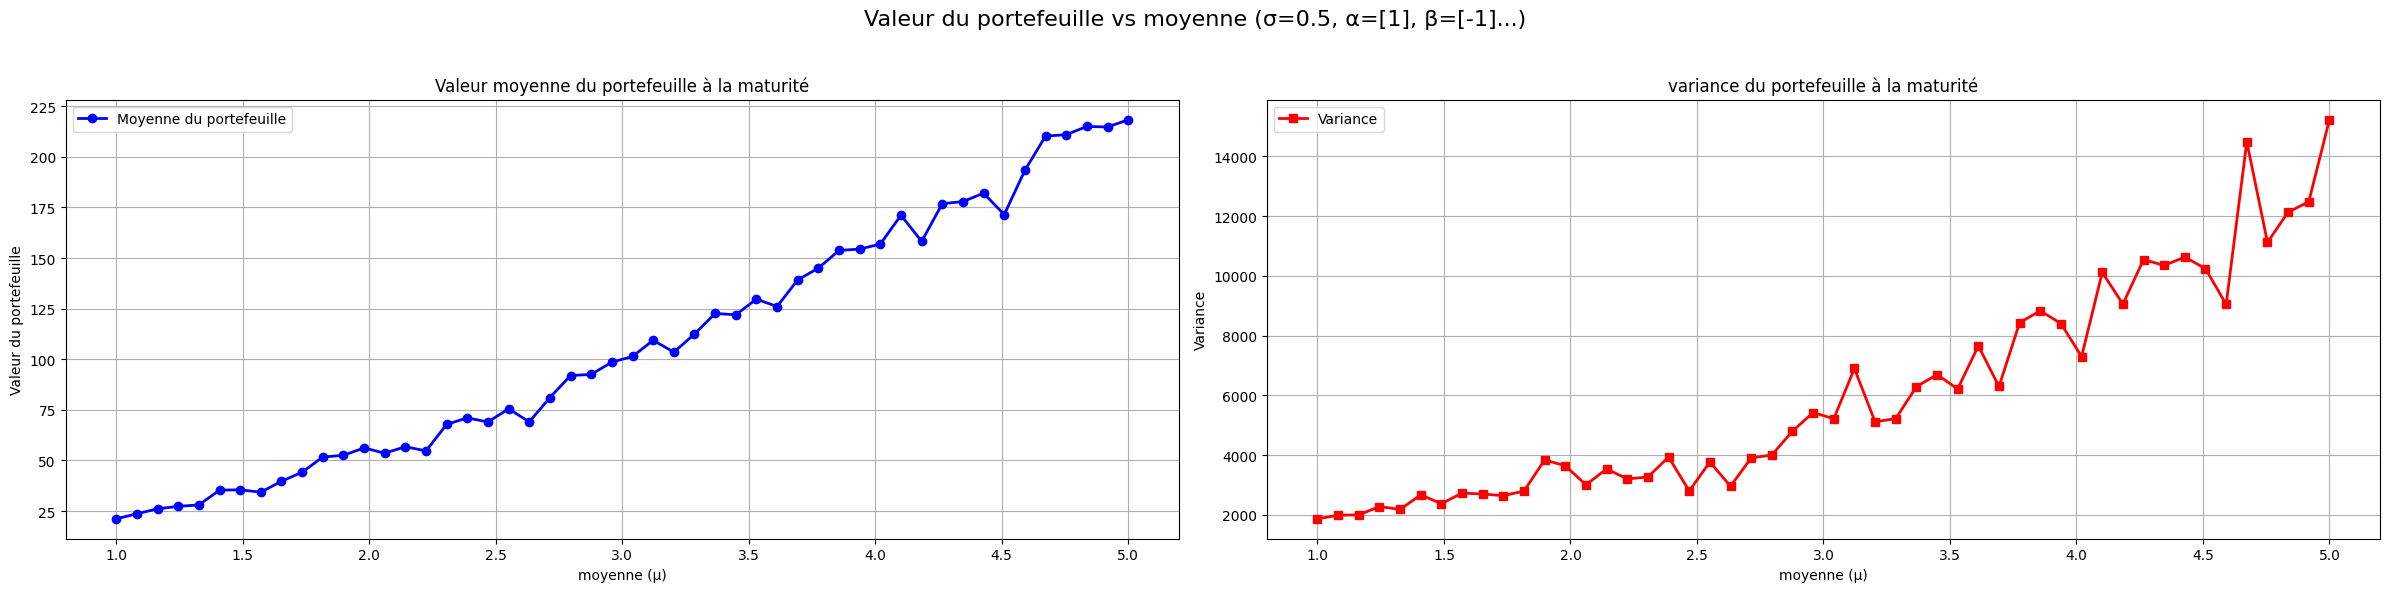

In [55]:
# Paramètres
S0 = 100
K = S0
sigma = 0.5
T = 1
N = 250
I0 = 1
n_iter = 250
alpha = np.array([1])
beta = np.array([-1])
mu_values = np.linspace(1, 5, 50)  
alpha = np.array([1])
beta = np.array([-1])

# Run simulations
reproductivité(will)
print("Running simulation for test...")
moyennes, variances = simulate_portfolio_values(mu_values, S0, K, sigma, T, N, dt, I0, n_iter, alpha, beta)
plot_results(mu_values, moyennes, variances, alpha, beta, sigma, test = True)

Ici on applique les codes de deteerminantion de probabilité par IS sur le portefeuille test pour differentes valeurs du $\text{seuil}$
On choisit : 
- $\text{seuil}_1$ = 0 cet évenement n'est pas rare, les 3 méthodes devraient bien marcher
- $\text{seuil}_2$= 200 cet évenement n'est pas très rare, les 3 méthodes devraient plutot bien marcher
- $\text{seuil}_3$ = 900 cet évenement est pas rare, les  méthodes  d' IS devraient bien marcher


--- Probabilité P(V_T >= 0) ---
Analytique : 4.012937e-01
Échantillonnage d’importance (μ=0.0000) : 3.982100e-01 ± 3.034133e-03
Échantillonnage Esscher (θ=0.0000) : 3.986300e-01 ± 3.034673e-03
Monte Carlo (μ=0) : 4.030700e-01 ± 3.040241e-03


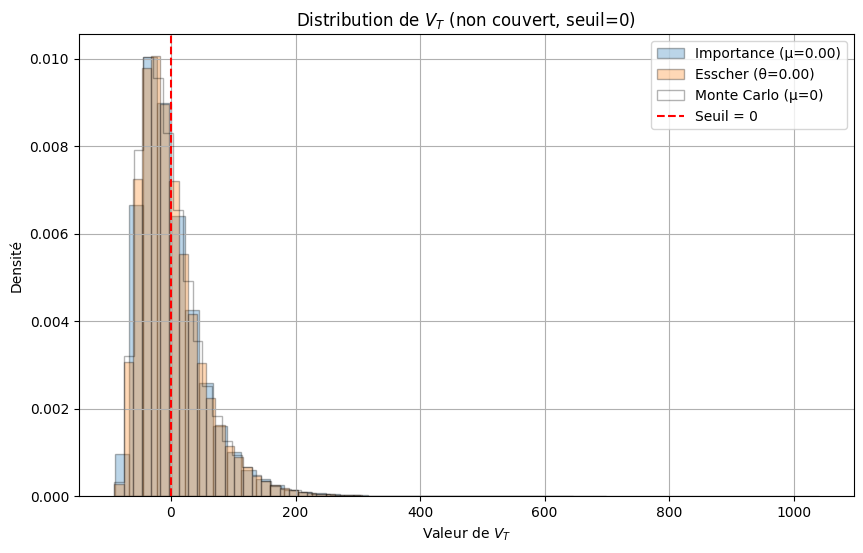


--- Probabilité P(V_T >= 200) ---
Analytique : 7.198055e-03
Échantillonnage d’importance (μ=2.1972) : 7.121994e-03 ± 7.819029e-05
Échantillonnage Esscher (θ=4.3944) : 7.178084e-03 ± 7.875502e-05
Monte Carlo (μ=0) : 7.120000e-03 ± 5.211280e-04


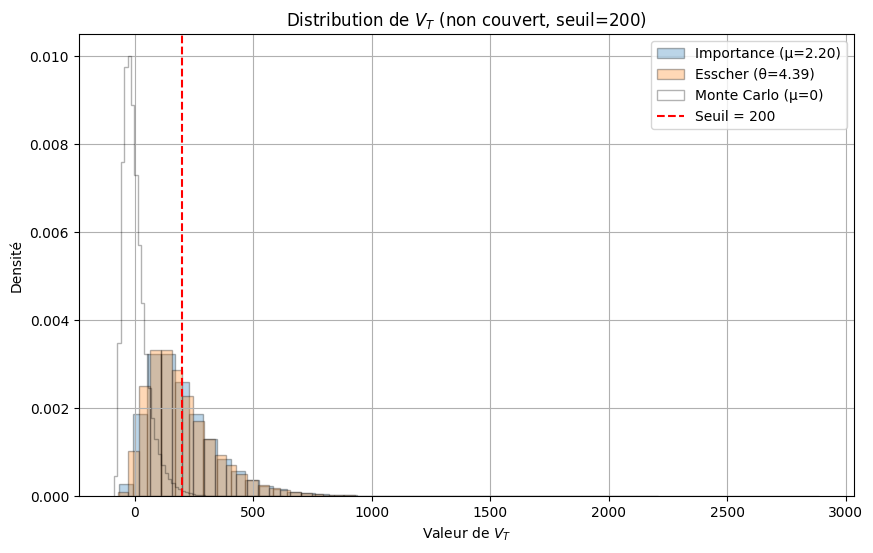


--- Probabilité P(V_T >= 1000) ---
Analytique : 2.258250e-07
Échantillonnage d’importance (μ=4.7958) : 2.257585e-07 ± 3.464253e-09
Échantillonnage Esscher (θ=9.5916) : 2.265836e-07 ± 3.472408e-09
Monte Carlo (μ=0) : 0.000000e+00 ± 0.000000e+00


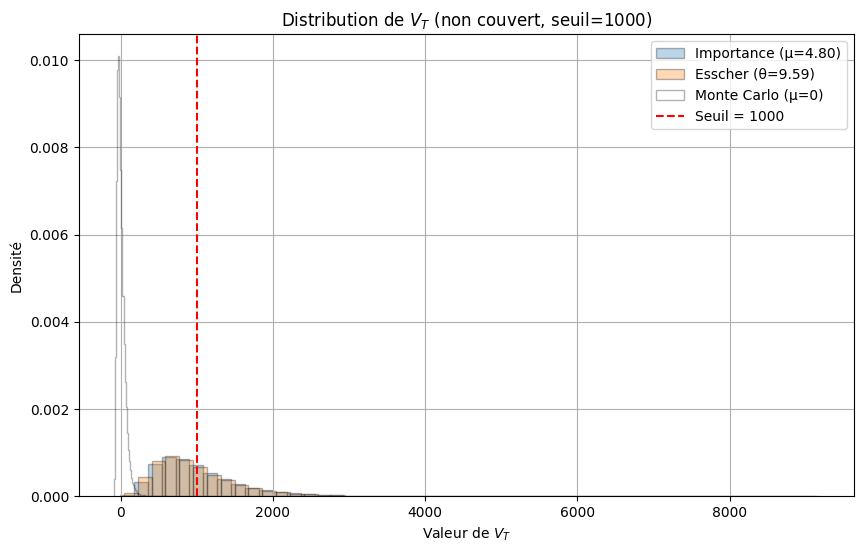

In [35]:

# Paramètres
S0 = 100
K = 100
sigma = 0.5
T = 1
N = 1000
I0 = 1
n_iter = 100000
alpha = np.array([1])
beta = np.array([-1])
seuils = [0, 200, 1000]

reproductivité(will)

for seuil in seuils :
    mu_optimal = np.log((seuil + K) / S0) /  (sigma * T) 
    theta_optimal = mu_optimal / sigma  
    # Calcul analytique
    d = (np.log((seuil + K) / S0) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    p_analytic = 1 - stats.norm.cdf(d)

    mu = 0 if seuil == 0 else mu_optimal
    # Échantillonnage d’importance (drift)
    p_hat_is, var_hat_is, V_T_is, weights_is = importance_sampling_probability(
        alpha, beta, T, K, sigma, S0, N, I0, n_iter, seuil, mu, "sup"
    )

    theta = 0 if seuil == 0 else theta_optimal
    # Échantillonnage d’importance (Esscher)
    p_hat_ess, var_hat_ess, V_T_ess, weights_ess = importance_sampling_esscher(
        alpha, beta, T, K, sigma, S0, N, I0, n_iter, seuil, theta, "sup"
    )

    # Monte Carlo
    p_hat_mc, var_hat_mc, V_T_mc, weights_mc = importance_sampling_probability(
        alpha, beta, T, K, sigma, S0, N, I0, n_iter, seuil, mu=0, type="sup"
    )

    # Résultats
    print(f"\n--- Probabilité P(V_T >= {seuil}) ---")
    print(f"Analytique : {p_analytic:.6e}")
    print(f"Échantillonnage d’importance (μ={mu:.4f}) : {p_hat_is:.6e} ± {1.96 * np.sqrt(var_hat_is):.6e}")
    print(f"Échantillonnage Esscher (θ={theta:.4f}) : {p_hat_ess:.6e} ± {1.96 * np.sqrt(var_hat_ess):.6e}")
    print(f"Monte Carlo (μ=0) : {p_hat_mc:.6e} ± {1.96 * np.sqrt(var_hat_mc):.6e}")

    # Histogramme
    plt.figure(figsize=(10, 6))
    plt.hist(V_T_is, bins=50, edgecolor='black', alpha=0.3, density=True, label=f"Importance (μ={mu:.2f})")
    plt.hist(V_T_ess, bins=50, edgecolor='black', alpha=0.3, density=True, label=f"Esscher (θ={theta:.2f})")
    plt.hist(V_T_mc, bins=50, edgecolor='black', alpha=0.3, density=True, label='Monte Carlo (μ=0)', histtype='step')
    plt.axvline(seuil, color='red', linestyle='--', label=f'Seuil = {seuil}')
    plt.title(f"Distribution de $V_T$ (non couvert, seuil={seuil})")
    plt.xlabel("Valeur de $V_T$")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True)
    plt.show()

## Mise en oeuvre sur les portefeuilles du sujet

Ici on applique nos méthodes d'IS sur les portefeuilles du sujet 

In [58]:
# Paramètres généraux
S0 = 100      # Prix initial
K = S0        # Strike
sigma = 0.5   # Volatilité
T = 1         # Maturité
N = 1000      # Nombre de pas de temps
dt = T / N    # Pas de temps
I0 = 10       # Nombre de trajectoires par simulation
n_iter = 10000 # Nombre de simulations 

reproductivité(will)

# Portefeuille 1
alpha1 = np.full(I0, 10)
beta1 = np.full(I0, 5)
seuil1 = 10000      # Seuil pour l'événement rare
mu1 = 1            # Paramètre de biais (drift)
theta1 = mu1 / sigma # Paramètre Esscher

# Portefeuille 2
alpha2 = np.full(I0, -10)
beta2 = np.full(I0, -5)
seuil2 = -9000      # Seuil pour l'événement rare
mu2 = 1             # Paramètre de biais (drift)
theta2 = mu2 / sigma 

# Portefeuille 3
alpha3 = np.array([-10] * 5 + [10] * 5)
beta3 = np.array([-5] * 5 + [5] * 5)
seuil3 = 10000       # Seuil pour l'événement rare
mu3 = 1.5             # Paramètre de biais (drift)
theta3 = mu3 / sigma 

# Exécuter les simulations pour chaque portefeuille
portfolios = [
    (1, alpha1, beta1, seuil1, mu1, theta1, "sup"),
    (2, alpha2, beta2, seuil2, mu2, theta2, "inf"),
    (3, alpha3, beta3, seuil3, mu3, theta3, "sup")
]

for portfolio_num, alpha, beta, seuil, mu, theta, type_prob in portfolios:
    print(f"\nRunning simulation for portfolio {portfolio_num}...")
    
    # Échantillonnage d'importance avec drift
    p_hat_drift, var_hat_drift, V_T_values_drift, _ = importance_sampling_probability(
        alpha, beta, T, K, sigma, S0, N, I0, n_iter, seuil, mu, type_prob
    )
    
    # Échantillonnage d'importance avec Esscher
    p_hat_ess, var_hat_ess, V_T_values_ess, _ = importance_sampling_esscher(
        alpha, beta, T, K, sigma, S0, N, I0, n_iter, seuil, theta, type_prob
    )

    
    # Affichage des résultats
    print("\nMéthode avec drift (μ):")
    print(f"Estimation : {p_hat_drift:.6e}")
    print(f"Intervalle de confiance à 95% : [{p_hat_drift - 1.96 * np.sqrt(var_hat_drift):.6e}, {p_hat_drift + 1.96 * np.sqrt(var_hat_drift):.6e}]")
    # Affichage des résultats
    print("\nMéthode avec changement de Esscher:")
    print(f"Estimation : {p_hat_ess:.6e}")
    print(f"Intervalle de confiance à 95% : [{p_hat_ess - 1.96 * np.sqrt(var_hat_ess):.6e}, {p_hat_ess + 1.96 * np.sqrt(var_hat_ess):.6e}]")
    
    


Running simulation for portfolio 1...

Méthode avec drift (μ):
Estimation : 1.209294e-04
Intervalle de confiance à 95% : [7.142425e-05, 1.704346e-04]

Méthode avec changement de Esscher:
Estimation : 9.795618e-05
Intervalle de confiance à 95% : [5.686386e-05, 1.390485e-04]

Running simulation for portfolio 2...

Méthode avec drift (μ):
Estimation : 3.348492e-04
Intervalle de confiance à 95% : [2.493664e-04, 4.203321e-04]

Méthode avec changement de Esscher:
Estimation : 8.150610e-04
Intervalle de confiance à 95% : [2.778932e-05, 1.602333e-03]

Running simulation for portfolio 3...

Méthode avec drift (μ):
Estimation : 3.433574e-07
Intervalle de confiance à 95% : [-3.208586e-07, 1.007573e-06]

Méthode avec changement de Esscher:
Estimation : 3.636580e-09
Intervalle de confiance à 95% : [1.039313e-09, 6.233847e-09]


# Determination des quantiles

Ici on implémente une fonction `importance_sampling_quantile` qui implémente la determination des quantiles avec méthode d'IS

In [ ]:
def importance_sampling_quantile(alpha, beta, T, K, sigma, S0, N, I0, n_iter, alpha_quantile, mu, n_bootstrap=100):
    dt = T / N
    sqrt_dt = np.sqrt(dt)
    t_grid = np.linspace(0, T, N + 1)
    
    V_T_values = np.zeros(n_iter)
    weights = np.zeros(n_iter)
    
    randoms = np.random.randn(n_iter, I0, N)
    W = np.zeros((n_iter, I0, N + 1))
    W[:, :, 1:] = np.cumsum(mu * dt + sqrt_dt * randoms, axis=2)
    
    drift = (- 0.5 * sigma**2) * t_grid
    S_paths = S0 * np.exp(drift + sigma * W)
    S_T = S_paths[:, :, -1]
    
    V_T_values = valeur_portefeuille_bis(alpha, beta, S_T, T, T, K, sigma)
    
    W_T = (np.log(S_T / S0) + 0.5 * sigma**2 * T - sigma * mu * T) / sigma
    log_weights = -mu * W_T - 0.5 * mu**2 * T
    total_log_weights = np.sum(log_weights, axis=1)
    weights = np.exp(total_log_weights)
    
    weights /= np.sum(weights)
    
    sorted_indices = np.argsort(V_T_values)
    V_T_sorted = V_T_values[sorted_indices]
    weights_sorted = weights[sorted_indices]
    cumulative_weights = np.cumsum(weights_sorted)
    
    idx = np.searchsorted(cumulative_weights, alpha_quantile)
    if idx == 0:
        q_alpha = V_T_sorted[0]
    elif idx >= len(V_T_sorted):
        q_alpha = V_T_sorted[-1]
    else:
        q_alpha = V_T_sorted[idx]


    # Bootstrap pour la variance
    q_alpha_bootstrap = np.zeros(n_bootstrap)
    for b in range(n_bootstrap):
        indices = np.random.choice(n_iter, size=n_iter, replace=True)

        V_T_b = V_T_values[indices]
        W_T_b = W_T[indices]

        log_weights_b = -mu * W_T_b - 0.5 * mu**2 * T
        total_log_weights_b = np.sum(log_weights_b, axis=1)
        weights_b = np.exp(total_log_weights_b)
        weights_b /= np.sum(weights_b)

        sorted_indices_b = np.argsort(V_T_b)
        V_T_sorted_b = V_T_b[sorted_indices_b]
        weights_sorted_b = weights_b[sorted_indices_b]
        cumulative_weights_b = np.cumsum(weights_sorted_b)

        idx_b = np.searchsorted(cumulative_weights_b, alpha_quantile)
        if idx_b == 0:
            q_alpha_b = V_T_sorted_b[0]
        elif idx_b >= len(V_T_sorted_b):
            q_alpha_b = V_T_sorted_b[-1]
        else:
            q_alpha_b = V_T_sorted_b[idx_b]

        q_alpha_bootstrap[b] = q_alpha_b
    var_q_alpha = np.var(q_alpha_bootstrap, ddof=1)
    
    return q_alpha, var_q_alpha, V_T_values, weights

## Test sur le portefeuille test

On essaye d'estimer le quantile d'ordre $\text{alpha\_quantile} = 0.9999999 $

mu = 1.80, Quantile estimé = 1138.38, Variance = 4.214051e+03
mu = 1.84, Quantile estimé = 1057.68, Variance = 1.908367e+03
mu = 1.87, Quantile estimé = 1057.42, Variance = 1.926333e+03
mu = 1.91, Quantile estimé = 1058.27, Variance = 4.786375e+03
mu = 1.95, Quantile estimé = 1021.04, Variance = 3.701513e+03
mu = 1.98, Quantile estimé = 1170.95, Variance = 1.660557e+03
mu = 2.02, Quantile estimé = 1052.01, Variance = 2.761491e+03
mu = 2.06, Quantile estimé = 1119.85, Variance = 1.455715e+03
mu = 2.09, Quantile estimé = 1195.42, Variance = 2.049853e+03
mu = 2.13, Quantile estimé = 1182.87, Variance = 2.894040e+03
mu = 2.17, Quantile estimé = 985.23, Variance = 1.399444e+03
mu = 2.21, Quantile estimé = 1060.39, Variance = 2.895699e+02
mu = 2.24, Quantile estimé = 1107.36, Variance = 7.111718e+02
mu = 2.28, Quantile estimé = 1113.54, Variance = 2.513395e+03
mu = 2.32, Quantile estimé = 1037.38, Variance = 7.675438e+02
mu = 2.35, Quantile estimé = 1139.94, Variance = 5.604653e+02
mu = 2.39

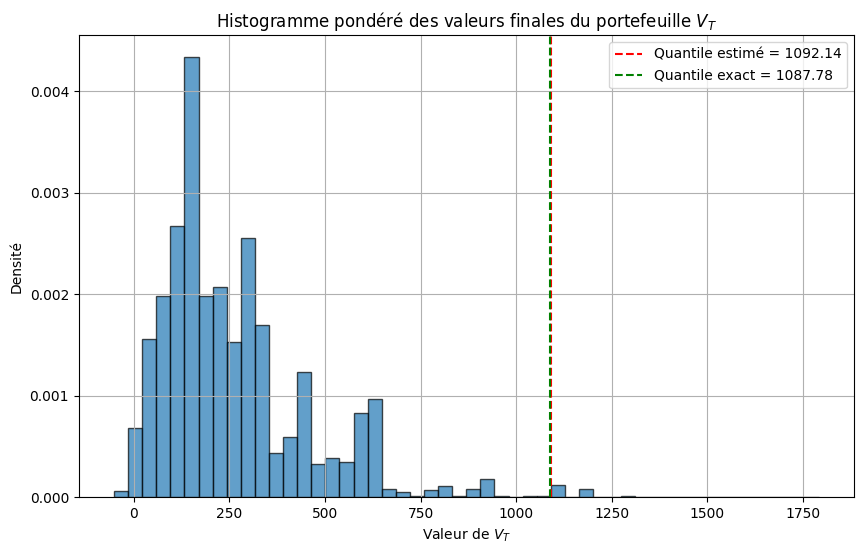

In [ ]:
# Paramètres
S0 = 100
K = 100
sigma = 0.5
T = 1
N = 1000
I0 = 1
n_iter = 10000  
alpha = np.array([1])
beta = np.array([-1])
alpha_quantile = 0.9999999
quant_alpha = S0 * np.exp(norm.ppf(alpha_quantile) * sigma * np.sqrt(T) - 0.5 * sigma**2 * T) - K

# Grille de mu à tester
mu_values = np.linspace(1.8, 2.5, 20)  # valeur optiamel autour de 1.1
q_alpha_estimates = []
var_estimates = []
V_T_mu_list = []


# Boucle sur les mu
for mu in mu_values:
    q_alpha, var_q_alpha, V_T_values, weights = importance_sampling_quantile(
        alpha, beta, T, K, sigma, S0, N, I0, n_iter, alpha_quantile, mu
    )
    q_alpha_estimates.append(q_alpha)
    var_estimates.append(var_q_alpha/q_alpha)
    V_T_mu_list.append(V_T_values)
    print(f"mu = {mu:.2f}, Quantile estimé = {q_alpha:.2f}, Variance = {var_q_alpha:.6e}")

# Choix du meilleur mu
best_mu_idx = np.argmin(var_estimates)
best_mu = mu_values[best_mu_idx]
q_alpha = q_alpha_estimates[best_mu_idx]
var_q_alpha = var_estimates[best_mu_idx]
V_T_values = V_T_mu_list[best_mu_idx]

print(f"\nMeilleur mu = {best_mu:.2f} (variance relative minimale = {var_q_alpha:.6e})")
print(f"Quantile à {alpha_quantile*100}% estimé : {q_alpha:.2f}")
print(f"Valeur exacte : {quant_alpha:.2f}")
print(f"Variance de l'estimateur : {var_q_alpha:.6e}")
print(f"Intervalle de confiance à 95% : [{q_alpha - 1.96 * np.sqrt(var_q_alpha):.2f}, {q_alpha + 1.96 * np.sqrt(var_q_alpha):.2f}]")

# Histogramme pondéré
plt.figure(figsize=(10, 6))
plt.hist(V_T_values, bins=50, edgecolor='black', alpha=0.7, weights=weights / np.sum(weights), density=True)
plt.axvline(q_alpha, color='red', linestyle='--', label=f'Quantile estimé = {q_alpha:.2f}')
plt.axvline(quant_alpha, color='green', linestyle='--', label=f'Quantile exact = {quant_alpha:.2f}')
plt.title("Histogramme pondéré des valeurs finales du portefeuille $V_T$")
plt.xlabel("Valeur de $V_T$")
plt.ylabel("Densité")
plt.grid(True)
plt.legend()
plt.show()


# Méthodes de splitting 

Ici nous implementons les différentes méthodes de splitting

## Splitting par méthode de rejet

In [ ]:
"""
fixer la limite de temps pour le rejet
"""
time_allowed = 60

In [24]:
def sample_cond(alpha: np.ndarray, beta: np.ndarray, T:float, K: float, sigma: float, S0: float, N: int, I0: int, step: float):
    V_T=sample(alpha, beta, T, K, sigma, S0, N, I0)
    while(V_T<step):
        V_T=sample(alpha, beta, T, K, sigma, S0, N, I0)
        #print(f"la valeur de V_T est {V_T}")
    return V_T

def mult_sample_cond(alpha: np.ndarray, beta: np.ndarray, T:float, K: float, sigma: float, S0: float, N: int, I0: int, seuil: float, n_iter:int):
    V_T_i=np.zeros(n_iter)
    for i in range(n_iter):
        V_T_i[i]=sample_cond(alpha, beta, T, K, sigma, S0, N, I0, seuil)
        #print(f"la valeur de V_T_i[{i}] est {V_T_i[i]}")   
    return V_T_i

In [ ]:
def splitting(a: np.ndarray, alpha: np.ndarray, beta: np.ndarray, T: float, K: float, sigma: float, S0: float, N: int, I0: int, n_iter: int, seuil: float):

    assert a[0] == -np.inf and a[-1] == seuil
    proba = 1
    log_p_hat = []
    var_log_p_hat = []
    start_time = time.time()

    for i in range(1, len(a)):
        elapsed = time.time() - start_time
        if elapsed > time_allowed :
            print(f"\n⚠️ Temps d'exécution > 2 minutes, arrêt de la méthode au niveau {i}.")
            break

        V_T_i = mult_sample_cond(alpha, beta, T, K, sigma, S0, N, I0, a[i-1], n_iter)
        p_i = np.mean(V_T_i >= a[i])
        if p_i == 0:
            print(f"\n⚠️ p_hat_{i} = 0, estimation arrêtée, IC non calculable.")
            return 0.0, 0.0, 0.0

        log_p_hat.append(np.log(p_i))
        var_log_p_hat.append((1 - p_i) / (n_iter * p_i))
        proba *= p_i
        print(f"proba stp{i}: {proba}")

    # Calcul de l’IC (intervalle de confiance) si on a assez de niveaux
    log_proba = sum(log_p_hat)
    var_log_proba = sum(var_log_p_hat)
    beta = np.sqrt(var_log_proba)
    lower = np.exp(log_proba - 1.96 * beta)
    upper = np.exp(log_proba + 1.96 * beta)

    return proba, lower, upper


### Test sur le portefeuille test

In [38]:
# Paramètres
S0 = 100
K = 100
sigma = 0.5
T = 1
I0 = 1
alpha = np.array([1])
beta = np.array([-1])
q = 10  
n = 1000  
N= 1000 
n_tour = 10
rho = 0.8  # Paramètre de corrélation
n_markov=10


reproductivité(will)

niveaux = 20  
a2 = np.linspace(100, 900, niveaux + 1)
a2[0] = -np.inf
seuil2 = a2[-1]

a1 = np.linspace(-10, 0, niveaux + 1)
a1[0] = -np.inf
seuil1 = a1[-1] 

# Boucle sur les deux cas
for i in range(2):
    # Sélection de la grille et du seuil
    a     = a1 if i == 0 else a2
    seuil = seuil1 if i == 0 else seuil2

    # Calcul analytique pour comparaison
    d = (np.log((seuil + K) / S0) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    p_analytic = 1 - stats.norm.cdf(d)

    print(f"\n-------- Estimation de P(V_T >= {seuil}) --------")

    # Appel à ta fonction splitting
    reproductivité(will)  
    p_hat, inf, sup = splitting(a, alpha, beta, T, K,
                    sigma, S0, N, I0, n,
                    seuil)
    
    # Affichage du résultat
    print(f"Estimation de P(V_T >= {seuil}) : {p_hat:.6e}, , IC(95%) = [{inf:.6e}, {sup:.6e}]")
    print(f"Valeur analytique attendue :   {p_analytic:.6e}")



-------- Estimation de P(V_T >= 0.0) --------
proba stp1: 0.457
proba stp2: 0.453344
proba stp3: 0.449717248
proba stp4: 0.446569227264
proba stp5: 0.442996673445888
proba stp6: 0.4381237100379832
proba stp7: 0.43461872035767934
proba stp8: 0.4294032957133872
proba stp9: 0.42339164957339975
proba stp10: 0.4174641664793722
proba stp11: 0.41370698898105784
proba stp12: 0.4099836260802283
proba stp13: 0.4071137406976667
proba stp14: 0.404263944512783
proba stp15: 0.4002213050676552
proba stp16: 0.394618206796708
proba stp17: 0.3934343521763179
proba stp18: 0.39068031171108364
proba stp19: 0.38599214797055065
proba stp20: 0.38213222649084516
Estimation de P(V_T >= 0.0) : 3.821322e-01, , IC(95%) = [3.554102e-01, 4.108634e-01]
Valeur analytique attendue :   4.012937e-01

-------- Estimation de P(V_T >= 900.0) --------
proba stp1: 0.021
proba stp2: 0.01008
proba stp3: 0.00497952
proba stp4: 0.00247980096
proba stp5: 0.0012051832665599998

⚠️ Temps d'exécution > 2 minutes, arrêt de la méthode

## MCMC splitting

In [59]:
def MCMC_splitting(a: np.ndarray, alpha: np.ndarray, beta: np.ndarray, T: float, K: float,
                   sigma: float, S0: float, N: int, I0: int, n_ech: int,
                   seuil: float, rho: float, n_markov: int,
                   type: str = "sup", text: bool = False):

    assert a[0] == -np.inf and a[-1] == seuil
    assert type in ("sup", "inf"), "type doit être 'sup' ou 'inf'"

    proba = 1.0
    log_p_hat = []
    var_log_p_hat = []
    L = len(a) - 1

    # Étape 1 : initialisation
    W = np.random.randn(n_ech, I0) * np.sqrt(T)
    S_T = S0 * np.exp((-0.5 * sigma ** 2) * T + sigma * W)
    V_T = valeur_portefeuille_bis(alpha, beta, S_T, T, T, K, sigma)

    for j in range(1, L + 1):
        # Étape 2 : sélection selon le type
        if type == "sup":
            indices_survivants = np.where(V_T > a[j])[0]
        else:  # type == "inf"
            indices_survivants = np.where(V_T < a[j])[0]

        W_survivants = W[indices_survivants]
        n_survivants = len(W_survivants)

        # Mise à jour de la proba
        p_j = n_survivants / n_ech
        proba *= p_j
        log_p_hat.append(np.log(p_j))
        var_log_p_hat.append((1 - p_j) / (n_ech * p_j))

        if text:
            print(f"Niveau {j} : seuil = {a[j]}, p_j = {p_j}")

        if n_survivants == 0:
            print("Extinction de la population : proba = 0")
            return 0.0

        # Étape 3 : Mutation MCMC
        W_new = list(W_survivants)

        while len(W_new) < n_ech:
            idx_parent = np.random.randint(n_survivants)
            W_parent = W_survivants[idx_parent]

            W_mutant = W_parent.copy()
            for _ in range(n_markov):
                proposal = rho * W_mutant + np.sqrt(1 - rho**2) * np.random.randn(I0) * np.sqrt(T)
                S_T_prop = S0 * np.exp((-0.5 * sigma ** 2) * T + sigma * proposal)
                V_T_prop = valeur_portefeuille_bis(alpha, beta, S_T_prop[np.newaxis, :], T, T, K, sigma)[0]

                if (type == "sup" and V_T_prop > a[j]) or (type == "inf" and V_T_prop < a[j]):
                    W_mutant = proposal  # acceptation

            W_new.append(W_mutant)

        W = np.array(W_new)
        S_T = S0 * np.exp((-0.5 * sigma ** 2) * T + sigma * W)
        V_T = valeur_portefeuille_bis(alpha, beta, S_T, T, T, K, sigma)
        
    log_proba = sum(log_p_hat)
    var_log_proba = sum(var_log_p_hat)
    beta = np.sqrt(var_log_proba)
    lower = np.exp(log_proba - 1.96 * beta)
    upper = np.exp(log_proba + 1.96 * beta)

    return proba, lower, upper



### Test sur le portefeuille test

In [60]:
# Paramètres
S0 = 100
K = 100
sigma = 0.5
T = 1
I0 = 1
alpha = np.array([1])
beta = np.array([-1])
q = 10  
n = 1000   
n_tour = 10
rho = 0.8  # Paramètre de corrélation
n_markov=10


reproductivité(will)

niveaux = 20  
a2 = np.linspace(100, 900, niveaux + 1)
a2[0] = -np.inf
seuil2 = a2[-1]

a1 = np.linspace(-10, 0, niveaux + 1)
a1[0] = -np.inf
seuil1 = a1[-1] 

for i in range(2) :

    a = a1 if i ==0 else a2
    seuil = seuil1 if i==0 else seuil2
    d = (np.log((a[-1] + K) / S0) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    p_analytic = 1-stats.norm.cdf(d)

    print(f"\n--------Estimation de P(V_T >= {a[-1]})-----------")
    p_hat, lower, upper = MCMC_splitting(a, alpha, beta, T, K,
                    sigma, S0, N, I0, n,
                    seuil, rho, n_markov, text=True)

    # Afficher les résultats
    print(f"\nEstimation de P(V_T >= {a[-1]}) : {p_hat:.6e}, intervalle de confiance: [{lower:.6e}; {upper:.6e}]")
    print(f"Valeur analytique attendue : {p_analytic:.6e}")



--------Estimation de P(V_T >= 0.0)-----------
Niveau 1 : seuil = -9.5, p_j = 0.488
Niveau 2 : seuil = -9.0, p_j = 0.99
Niveau 3 : seuil = -8.5, p_j = 0.991
Niveau 4 : seuil = -8.0, p_j = 0.987
Niveau 5 : seuil = -7.5, p_j = 0.994
Niveau 6 : seuil = -7.0, p_j = 0.989
Niveau 7 : seuil = -6.5, p_j = 0.988
Niveau 8 : seuil = -6.0, p_j = 0.99
Niveau 9 : seuil = -5.5, p_j = 0.991
Niveau 10 : seuil = -5.0, p_j = 0.991
Niveau 11 : seuil = -4.5, p_j = 0.99
Niveau 12 : seuil = -4.0, p_j = 0.995
Niveau 13 : seuil = -3.5, p_j = 0.99
Niveau 14 : seuil = -3.0, p_j = 0.988
Niveau 15 : seuil = -2.5, p_j = 0.986
Niveau 16 : seuil = -2.0, p_j = 0.994
Niveau 17 : seuil = -1.5, p_j = 0.987
Niveau 18 : seuil = -1.0, p_j = 0.989
Niveau 19 : seuil = -0.5, p_j = 0.991
Niveau 20 : seuil = 0.0, p_j = 0.983

Estimation de P(V_T >= 0.0) : 4.007027e-01, intervalle de confiance: [3.739028e-01; 4.294235e-01]
Valeur analytique attendue : 4.012937e-01

--------Estimation de P(V_T >= 900.0)-----------
Niveau 1 : seui

### Mise en oeuvre sur les portefeuilels du sujet 

In [62]:
def grille_niveaux_hybride(seuil, valeur_min, n_niveaux_non_rares,  pas_queue=0.5, delta=10):
    
    # Partie dans la zone rare
    a_rare = np.arange(seuil - delta, seuil + pas_queue, pas_queue)

    a_non_rare = np.linspace(0, 1, n_niveaux_non_rares)
    a_non_rare = valeur_min + (seuil - delta - valeur_min) * (a_non_rare ** 2)  

    # Fusion
    a_total = np.concatenate((a_non_rare, a_rare[1:]))  
    a_total[0] = -np.inf 
    a_total[-1] = seuil 
    
    return a_total



In [63]:
# Paramètres généraux
S0 = 100      # Prix initial
K = S0        # Strike
sigma = 0.5   # Volatilité
T = 1         # Maturité
N = 1000      # Nombre de pas de temps
dt = T / N    # Pas de temps
I0 = 10       # Nombre de trajectoires par simulation
n_iter = 10000 # Nombre de simulations 

reproductivité(will)

# Portefeuille 1
alpha1 = np.full(I0, 10)
beta1 = np.full(I0, 5)
seuil1 = 10000      # Seuil pour l'événement rare

# Portefeuille 2
alpha2 = np.full(I0, -10)
beta2 = np.full(I0, -5)
seuil2 = -9000      # Seuil pour l'événement rare
# Portefeuille 3
alpha3 = np.array([-10] * 5 + [10] * 5)
beta3 = np.array([-5] * 5 + [5] * 5)
seuil3 = 10000       # Seuil pour l'événement rare

# Exécuter les simulations pour chaque portefeuille
portfolios = [
    (1, alpha1, beta1, seuil1, mu1, theta1, "sup"),
    (2, alpha2, beta2, seuil2, mu2, theta2, "inf"),
    (3, alpha3, beta3, seuil3, mu3, theta3, "sup")
]

for portfolio_num, alpha, beta, seuil, mu, theta, type_prob in portfolios:
    print(f"\nRunning simulation for portfolio {portfolio_num}...")
    
    if portfolio_num == 1 : 
        a = grille_niveaux_hybride(seuil1, 5000, 100)

    if portfolio_num == 2 : 
        a = grille_niveaux_hybride(seuil2, -5000, 100)
    
    if portfolio_num == 3 : 
        niveaux = 1000  
        a = np.linspace(1000, 10000, niveaux + 1)
        a[0] = -np.inf
        seuil = a[-1]

    # Échantillonnage d'importance avec drift
    p_hat, lower, upper = MCMC_splitting(a, alpha, beta, T, K,
                    sigma, S0, N, I0, n,
                    seuil, rho, n_markov, type = type_prob)
    
    # Affichage des résultats
    print("Méthode de splitting MC:")
    print(f"Estimation : {p_hat:.6e}, intervalle de confiance: [{lower:.6e}; {upper:.6e}]")


Running simulation for portfolio 1...
Méthode de splitting MC:
Estimation : 1.546291e-04, intervalle de confiance: [1.171485e-04; 2.041013e-04]

Running simulation for portfolio 2...
Méthode de splitting MC:
Estimation : 6.065515e-04, intervalle de confiance: [4.607755e-04; 7.984467e-04]

Running simulation for portfolio 3...
Méthode de splitting MC:
Estimation : 1.807989e-06, intervalle de confiance: [1.403625e-06; 2.328845e-06]


## Algorithme de la derniere particule 

In [51]:
def last_particle_algorithm(alpha, beta, T, K, sigma, S0, I0, n, n_tour, q, rho=0.9, type="sup"):
    assert type in ("sup", "inf"), "type doit être 'sup' ou 'inf'"

    # Initialisation
    W = np.random.randn(n, I0) * np.sqrt(T)
    S_T = S0 * np.exp((-0.5 * sigma**2) * T + sigma * W)
    V_T = valeur_portefeuille_bis(alpha, beta, S_T, T, T, K, sigma)

    L_values = []
    j = 0

    while True:
        # Étape 1 : niveau L_j
        if type == "sup":
            L_j = np.min(V_T)
        else:
            L_j = np.max(V_T)
        L_values.append(L_j)

        # Étape 2 : critère d’arrêt
        if (type == "sup" and L_j > q) or (type == "inf" and L_j < q):
            break

        # Étape 3 : sélection de la particule extrême
        m_star = np.argmin(V_T) if type == "sup" else np.argmax(V_T)

        # Sélection des candidats valides
        if type == "sup":
            valid_indices = np.where(V_T > L_j)[0]
        else:
            valid_indices = np.where(V_T < L_j)[0]

        if len(valid_indices) == 0:
            break  # extinction

        W_0 = W[np.random.choice(valid_indices)]

        # Mutation conditionnelle
        for _ in range(n_tour):
            W_half = rho * W_0 + np.sqrt(1 - rho**2) * np.random.randn(I0) * np.sqrt(T)
            S_T_half = S0 * np.exp((-0.5 * sigma**2) * T + sigma * W_half)
            V_T_half = valeur_portefeuille_bis(alpha, beta, S_T_half[np.newaxis, :], T, T, K, sigma)[0]

            if (type == "sup" and V_T_half > L_j) or (type == "inf" and V_T_half < L_j):
                W_0 = W_half

        # Mise à jour de la particule extrême
        W[m_star] = W_0
        S_T[m_star] = S0 * np.exp((-0.5 * sigma**2) * T + sigma * W_0)
        V_T[m_star] = valeur_portefeuille_bis(alpha, beta, S_T[m_star:m_star+1, :], T, T, K, sigma)[0]

        j += 1

    # Estimateur final
    p_hat = (1 - 1 / n) ** j
    r = 1.96 * np.sqrt(-np.log(p_hat)) / np.sqrt(n)
    return p_hat, j, L_values, r


### Test sur le portefeuille test

Estimation de P(V_T >= 200) : 8.384327e-03 ± 1.136322e-03
Nombre d'itérations (J_n) : 4779
Valeur analytique attendue : 7.198055e-03


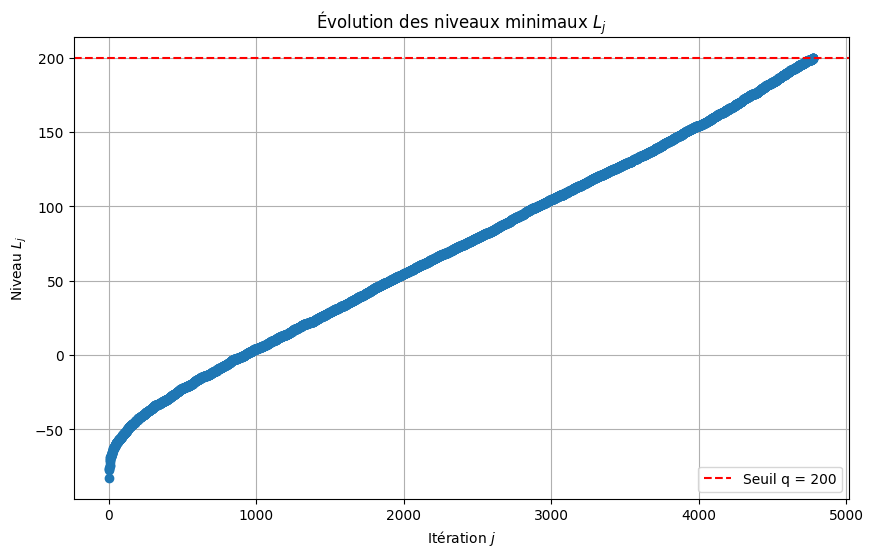

In [54]:
# Paramètres
S0 = 100
K = 100
sigma = 0.5
T = 1
I0 = 1
alpha = np.array([1])
beta = np.array([-1])
q = 200 
n = 1000   
n_tour = 10
rho = 0.8  # Paramètre de corrélation
d = (np.log((q + K) / S0) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
p_analytic = 1-stats.norm.cdf(d)

reproductivité(will)

p_hat, J_n, L_values, r = last_particle_algorithm(alpha, beta, T, K, sigma, S0, I0, n,n_tour,  q, rho)

# Afficher les résultats
print(f"Estimation de P(V_T >= {q}) : {p_hat:.6e} ± {p_hat * r :.6e}")
print(f"Nombre d'itérations (J_n) : {J_n}")
print(f"Valeur analytique attendue : {p_analytic:.6e}")

# Visualisation des niveaux L_j
plt.figure(figsize=(10, 6))
plt.plot(range(len(L_values)), L_values, marker='o')
plt.axhline(y=q, color='red', linestyle='--', label=f'Seuil q = {q}')
plt.title("Évolution des niveaux minimaux $L_j$")
plt.xlabel("Itération $j$")
plt.ylabel("Niveau $L_j$")
plt.grid(True)
plt.legend()
plt.show()

### Mise en oeure sur les portefeuilles du sujet

In [ ]:
# Paramètres généraux
S0 = 100      # Prix initial
K = S0        # Strike
sigma = 0.5   # Volatilité
T = 1         # Maturité
N = 1000      # Nombre de pas de temps
dt = T / N    # Pas de temps
I0 = 10       # Nombre de trajectoires par simulation
n_iter = 10000 # Nombre de simulations 

reproductivité(will)

# Portefeuille 1
alpha1 = np.full(I0, 10)
beta1 = np.full(I0, 5)
seuil1 = 10000      # Seuil pour l'événement rare


# Portefeuille 2
alpha2 = np.full(I0, -10)
beta2 = np.full(I0, -5)
seuil2 = -9000      # Seuil pour l'événement rare


# Portefeuille 3
alpha3 = np.array([-10] * 5 + [10] * 5)
beta3 = np.array([-5] * 5 + [5] * 5)
seuil3 = 9000       # Seuil pour l'événement rare

# Exécuter les simulations pour chaque portefeuille
portfolios = [
    (1, alpha1, beta1, seuil1, "sup"),
    (2, alpha2, beta2, seuil2, "inf"),
    (3, alpha3, beta3, seuil3, "sup")
]

for portfolio_num, alpha, beta, seuil, type_prob in portfolios:
    print(f"\nRunning simulation for portfolio {portfolio_num}...")
    
    # Échantillonnage d'importance avec drift
    p_hat, J_n, L_values, r  = last_particle_algorithm(
        alpha, beta, T, K, sigma, S0, I0, n,n_tour,  seuil, rho, type= type_prob
    )
   
    # Affichage des résultats
    print("Méthode de la derniere particule:")
    print(f"Estimation : {p_hat:.6e} ± {p_hat * r}")
    


Running simulation for portfolio 1...
Méthode de la derniere particule:
Estimation : 1.873950e-04 ± 3.40263773250039e-05

Running simulation for portfolio 2...
Méthode de la derniere particule:
Estimation : 4.657616e-04 ± 7.995938758756982e-05

Running simulation for portfolio 3...
Méthode de la derniere particule:
Estimation : 6.350452e-06 ± 1.3616111728573533e-06


## Détermination de quantile : Méthode de la derniere particule

In [ ]:
# Algorithme de la dernière particule pour le quantile
def last_particle_quantile(alpha, beta, T, K, sigma, S0, I0, n, n_tour, alpha_quantile, rho):
    
    # Calcul du nombre d'itérations cible
    j_n = int(np.ceil(np.log(alpha_quantile) / np.log(1 - 1/n)))
    
    # Calcul des bornes de l'intervalle de confiance
    j_n_minus = int(np.floor(-n * np.log(alpha_quantile) - 1.96 * np.sqrt(-n * np.log(alpha_quantile))))
    j_n_plus = int(np.ceil(-n * np.log(alpha_quantile) + 1.96 * np.sqrt(-n * np.log(alpha_quantile))))
    
    # Initialisation
    W = np.random.randn(n, I0) * np.sqrt(T)  # n particules W ~ N(0, T)
    S_T = S0 * np.exp((-0.5 * sigma**2) * T + sigma * W)  # Calcul de S_T
    V_T = valeur_portefeuille_bis(alpha, beta, S_T, T, T, K, sigma)  # Calcul de V_T
    
    L_values = []  # Stockage des niveaux L_j
    j = 0  # Compteur d'itérations
    
    # Itérations
    while j < j_n:
        # Étape 1 : Calcul du niveau minimal L_j
        L_j = np.min(V_T)
        L_values.append(L_j)
        
        # Étape 2 : Mise à jour des trajectoires
        # Identifier la particule réalisant le minimum
        m_star = np.argmin(V_T)
        
        # Sélectionner une particule parmi celles où V_T > L_j
        valid_indices = np.where(V_T > L_j)[0]
        if len(valid_indices) == 0:
            break  # Extinction
        
        W_0 = W[np.random.choice(valid_indices)]  # Tirage uniforme
        
        # Mutation conditionnelle
        for _ in range(n_tour):
            W_half = rho * W_0 + np.sqrt(1 - rho**2) * np.random.randn(I0) * np.sqrt(T)
            S_T_half = S0 * np.exp((-0.5 * sigma**2) * T + sigma * W_half)
            V_T_half = valeur_portefeuille_bis(alpha, beta, S_T_half[np.newaxis, :], T, T, K, sigma)[0]
            
            if V_T_half > L_j:
                W_0 = W_half
        
        # Remplacer la particule minimale
        W[m_star] = W_0
        S_T[m_star] = S0 * np.exp((-0.5 * sigma**2) * T + sigma * W_0)
        V_T[m_star] = valeur_portefeuille_bis(alpha, beta, S_T[m_star:m_star+1, :], T, T, K, sigma)[0]
        
        j += 1
    
    # Estimateur du quantile
    if j < j_n:
        print(f"Attention : arrêt prématuré après {j} itérations (j_n = {j_n})")
        q_hat = L_values[-1] if L_values else np.nan
        confidence_interval = [q_hat, q_hat]  # Intervalle dégénéré
    else:
        q_hat = L_values[j_n - 1] if j_n <= len(L_values) else L_values[-1]
        # Intervalle de confiance
        j_n_minus = max(0, min(j_n_minus, len(L_values) - 1))
        j_n_plus = max(0, min(j_n_plus, len(L_values) - 1))
        confidence_interval = [L_values[j_n_minus], L_values[j_n_plus]]
    
    return q_hat, j_n, L_values, confidence_interval

### Test sur le portefeuille test

Estimation du quantile à alpha = 1e-07: 1102.04
Valeur analytique : 1087.78
Nombre d'itérations (j_n) : 16111
Intervalle de confiance à 95% : [1076.51, 1102.04]


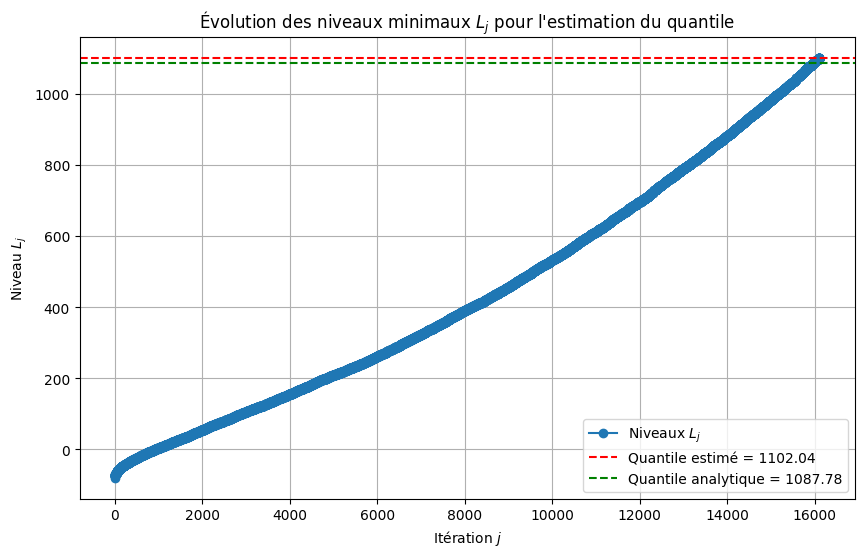

In [ ]:
# Paramètres pour le test
S0 = 100
K = 100
sigma = 0.5
T = 1
I0 = 1
alpha = np.array([1])
beta = np.array([-1])
alpha_quantile = 0.0000001  
n = 1000  
n_tour = 10  
rho = 0.9

# Valeur analytique du quantile
quant_alpha = S0 * np.exp(norm.ppf(1 - alpha_quantile) * sigma * np.sqrt(T) - 0.5 * sigma**2 * T) - K

# Exécuter l'algorithme
q_hat, j_n, L_values, confidence_interval = last_particle_quantile(
    alpha, beta, T, K, sigma, S0, I0, n, n_tour, alpha_quantile, rho
)

# Afficher les résultats
print(f"Estimation du quantile à alpha = {alpha_quantile}: {q_hat:.2f}")
print(f"Valeur analytique : {quant_alpha:.2f}")
print(f"Nombre d'itérations (j_n) : {j_n}")
print(f"Intervalle de confiance à 95% : [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]")

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(range(len(L_values)), L_values, marker='o', label='Niveaux $L_j$')
plt.axhline(y=q_hat, color='red', linestyle='--', label=f'Quantile estimé = {q_hat:.2f}')
plt.axhline(y=quant_alpha, color='green', linestyle='--', label=f'Quantile analytique = {quant_alpha:.2f}')
plt.title("Évolution des niveaux minimaux $L_j$ pour l'estimation du quantile")
plt.xlabel("Itération $j$")
plt.ylabel("Niveau $L_j$")
plt.grid(True)
plt.legend()
plt.show()


=== Portefeuille 1 ===
Estimation du quantile à alpha = 0.0001: 10327.29
Nombre d'itérations (j_n) : 9206
Intervalle de confiance à 95% : [10177.60, 10327.29]

=== Portefeuille 2 ===
Estimation du quantile à alpha = 0.0001: -736.76
Nombre d'itérations (j_n) : 9206
Intervalle de confiance à 95% : [-752.02, -736.76]

=== Portefeuille 3 ===
Estimation du quantile à alpha = 0.0001: 6518.56
Nombre d'itérations (j_n) : 9206
Intervalle de confiance à 95% : [6380.38, 6518.56]


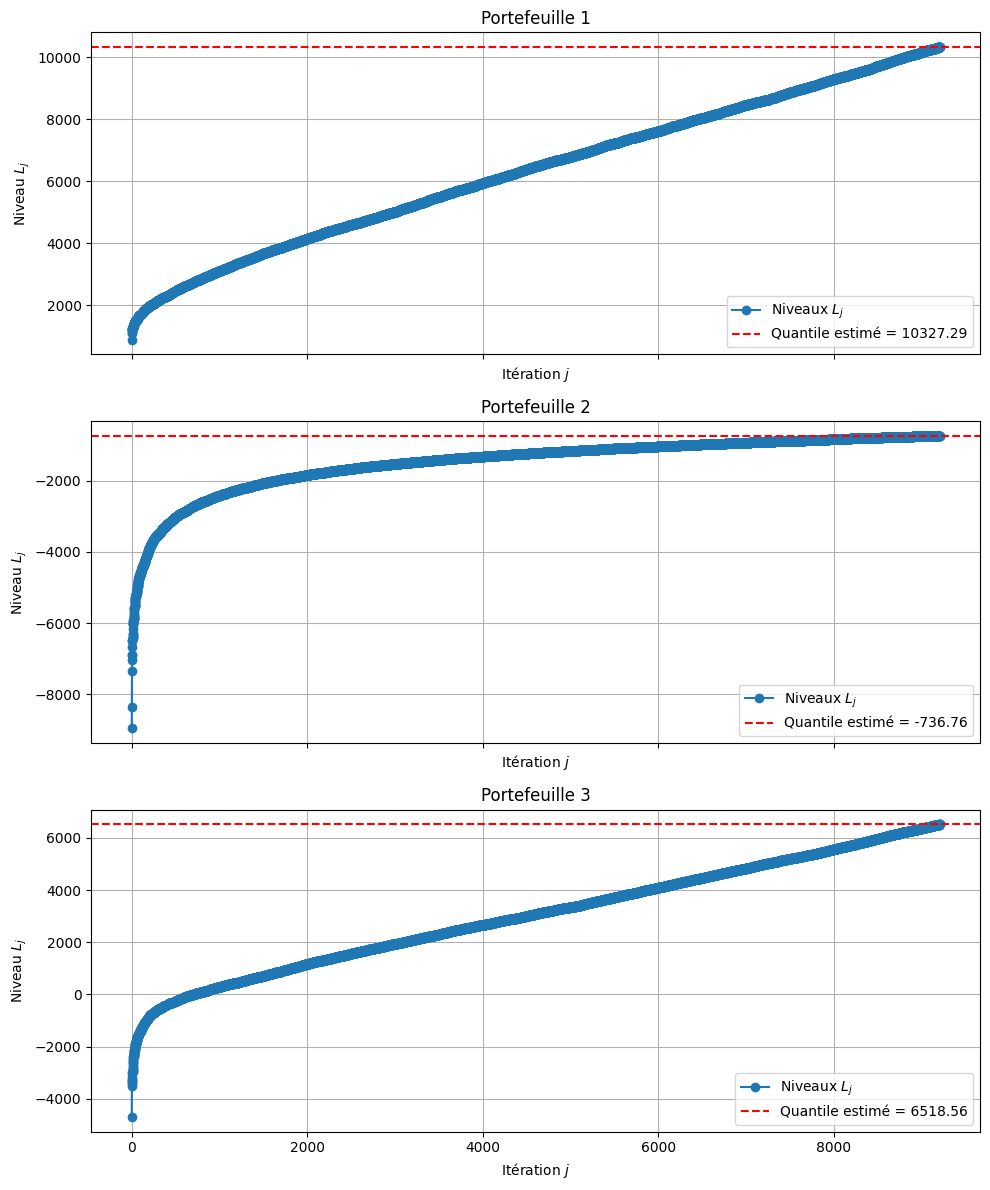

In [ ]:
# Paramètres généraux
S0 = 100
K = 100
sigma = 0.5
T = 1
N = 1000
I0 = 10
n_iter = 10000  # Non utilisé ici, mais conservé pour référence
n = 1000  # Nombre de particules
n_tour = 10
rho = 0.9
alpha_quantile = 0.0001


# Portefeuille 1
alpha1 = np.full(I0, 10)
beta1 = np.full(I0, 5)

# Portefeuille 2
alpha2 = np.full(I0, -10)
beta2 = np.full(I0, -5)

# Portefeuille 3
alpha3 = np.array([-10] * 5 + [10] * 5)
beta3 = np.array([-5] * 5 + [5] * 5)

# Liste des portefeuilles
portfolios = [
    ("Portefeuille 1", alpha1, beta1),
    ("Portefeuille 2", alpha2, beta2),
    ("Portefeuille 3", alpha3, beta3)
]

# Exécuter l'algorithme pour chaque portefeuille
results = []
for name, alpha, beta in portfolios:
    print(f"\n=== {name} ===")
    q_hat, j_n, L_values, confidence_interval = last_particle_quantile(
        alpha, beta, T, K, sigma, S0, I0, n, n_tour, alpha_quantile, rho
    )
    results.append((name, q_hat, j_n, L_values, confidence_interval))
    
    # Afficher les résultats
    print(f"Estimation du quantile à alpha = {alpha_quantile}: {q_hat:.2f}")
    print(f"Nombre d'itérations (j_n) : {j_n}")
    print(f"Intervalle de confiance à 95% : [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]")

# Visualisation
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
for idx, (name, q_hat, j_n, L_values, confidence_interval) in enumerate(results):
    ax = axes[idx]
    ax.plot(range(len(L_values)), L_values, marker='o', label='Niveaux $L_j$')
    ax.axhline(y=q_hat, color='red', linestyle='--', label=f'Quantile estimé = {q_hat:.2f}')
    ax.set_title(f"{name}")
    ax.set_xlabel("Itération $j$")
    ax.set_ylabel("Niveau $L_j$")
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.show()